This notebook describes the temporal fusion transformers [@lim2021temporal] architecture, and ports it over to keras 3 while making some punctual improvements, including bringing the notation closer to the one in the paper.

The original repository is [here](https://github.com/google-research/google-research/tree/master/tft).

In [1]:
#| output: false

from __future__ import annotations

import os
os.environ["KERAS_BACKEND"] = "tensorflow"
import keras
from keras import layers

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random

from datetime import timedelta
from dateutil.relativedelta import relativedelta
from fastcore import docments
from nbdev.showdoc import show_doc
from sklearn.preprocessing import StandardScaler

2024-01-08 05:08:56.681529: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Introduction

The main characteristics of TFT that make it interesting for nowcasting or forecasting purposes are:

- **multi-horizon forecasting**: the ability to output, at each point in time $t$, a sequence of forecasts for $t+h, h > 1$
- **quantile prediction**: each forecast is accompanied by a quantile band that communicates the amount of uncertainty around a prediction
- **flexible use of different types of inputs**: static inputs (akin to fixed effects), historical input and known future input (eg, important holidays, years that are known to have major sports events such as Olympic games, etc)
- **interpretability**: the model learns to select variables from the space of all input variables to retain only those that are globally meaningful, to assign attention to different parts of the time series, and to identify events of significance

## Main innovations

The present model includes the following innovations:

- **Multi-frequency input**

- **Context enhancement from lagged target**: the last known values of the target variable are embedded (bag of observations), and this embedding is used similar to the static context enhancement as a starting point for the cell value in the *decoder* LSTM.

# Preparing the data

The functions below will be tested with simulated and real data. The former helps to illustrate issues like dimensions and overall behaviour of a layer, whereas the latter will demonstrate on a real setting in economics how the input and output data relate to one another.

More specifically, the real data used will be a daily nowcasting exercise of monthly inflation. Note that the models will not necessarily perform well, since their use here is for illustration purposes and thus they are not optimised. Also, the dataset is not an ideal one for nowcasting: other variables could also be considered.

## Download economic data

This is a panel dataset. In addition to the time dimension, it can contain any number of categorical dimensions - for example, combine country and sector.

In [2]:
#| warning: false

df_all = pd.read_csv("data/nowcast_dataset_complete_Dec-08-2023.csv")
df_all['index'] = pd.to_datetime(df_all['index'])

/var/folders/b9/p8z57lqd55xfk68xz34dg0s40000gn/T/ipykernel_10035/384472896.py:3: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_all = pd.read_csv("data/nowcast_dataset_complete_Dec-08-2023.csv")


## Prepare data

In [3]:
countries = ['AU', 'CA', 'CH', 'DE', 'FR', 'GB', 'IN', 'JP', 'US']

filter_freq_d = df_all['frequency'] == 'd'
filter_cty = df_all['country'].isin(countries)
filter_dates = df_all['index'] >= '1980-01-01'

In [4]:
df_input = df_all[filter_freq_d & filter_cty & filter_dates].copy()
df_input.drop (['Unnamed: 0', 'frequency'], axis=1, inplace=True)
df_input.set_index(['index', 'country'], inplace=True) 
df_input = df_input.unstack('country')
df_input.columns = ['__'.join(col).strip() for col in df_input.columns.values]
df_input.dropna(how='all', inplace=True)

In [5]:
target_var = 'CPIh'
df_target = df_all.loc[
    (df_all['frequency'] == 'm') & (df_all['country'].isin(countries)) & filter_dates,
    ['index', 'country'] + [target_var]
] \
    .set_index(['index', 'country']) \
    .unstack('country') \
    .droplevel(0, axis=1) \
    .dropna()

In [6]:
df_target_12m_pct = (100 * df_target.pct_change(12))
df_target_1m_pct = (100 * df_target.pct_change(1))

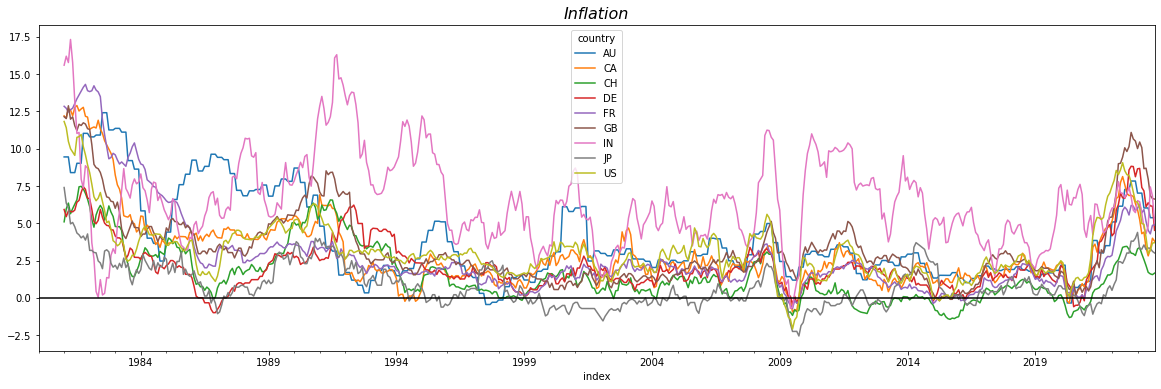

In [7]:
#| fig-align: center

ax = df_target_12m_pct.plot(figsize=(20, 6))
ax.axhline(y=0, color='black')
ax.set_title("Inflation", fontsize=16, fontstyle='italic')
plt.show()

## Date features

In addition to data provided by the user, the model automatically loads categorical features related to each date.

In [8]:
def date_features(
    date_range, # Range of dates for which to create date features
)->pd.DataFrame: # Categorical date features
    "Categorical features for each day in a range of dates"
    return pd.DataFrame({
        'Day of Week': date_range.dayofweek + 1, # This is the only date feature with zeros, which are masked out
        'Day of Month': date_range.day,
        'Day of Year': date_range.dayofyear,
        'Week of Month': (date_range.day - 1) // 7 + 1,
        'Week of Year': pd.Index(date_range.isocalendar().week).astype('int32'),
        'Month of Year': date_range.month
    })


In [9]:
#| output: asis
#| echo: false

show_doc(date_features, title_level=3)

---

### date_features

>      date_features (date_range)

Categorical features for each day in a range of dates

|    | **Type** | **Details** |
| -- | -------- | ----------- |
| date_range |  | Range of dates for which to create date features |
| **Returns** | **pd.DataFrame** | **Categorical date features** |

#### Example usage, real data

In [10]:
#| code-fold: show

date_features(df_input.index)[:10]

,Day of Week,Day of Month,Day of Year,Week of Month,Week of Year,Month of Year
0,2,1,1,1,1,1
1,3,2,2,1,1,1
2,4,3,3,1,1,1
3,5,4,4,1,1,1
4,1,7,7,1,2,1
5,2,8,8,2,2,1
6,3,9,9,2,2,1
7,4,10,10,2,2,1
8,5,11,11,2,2,1
9,1,14,14,2,3,1


### Combining the date features in the main data

In [11]:
date_feat = date_features(df_input.index)
date_feat.index = df_input.index
df_input = pd.concat([df_input, date_feat], axis=1)

## Splitting the dataset

This step needs to be done somewhat differently than normal datasets: In the validation and test periods, the input data can very well be from the previous chunk (training and validation, respectively).

In practice, this means that we just need to split the **dates** at which the nowcasting will take place. Then, a data loading function (see @sec-dataloaders) can read from the whole time series to look back from that date as needed according to the desired time window.

In [12]:
start_date = df_input.index.min()
end_date = df_input.index.max()
cutoff_date_train = pd.to_datetime('2005-01-01')
cutoff_date_valid = pd.to_datetime('2020-01-01')

dates_train = pd.date_range(start_date, cutoff_date_train - timedelta(days=1))
dates_valid = pd.date_range(cutoff_date_train, cutoff_date_valid - timedelta(days=1))
dates_test = pd.date_range(cutoff_date_valid, end_date)

Now all input variables that are not available in the training dataset are removed, and only those with at least some information are kept.

In [13]:
keep_cols = df_input.loc[min(dates_train):max(dates_train)].dropna(axis=1, how='all').columns
df_input = df_input[keep_cols]

## Identifying continuous and categorical variables {#sec-contcat}

 The model distinguishes continuous from categorical variables if the user does not provide a list of variable names in a simple (simplistic) way: integer-valued variables that start with one are considered categorical, all other are continuous.

The criteria that categorical variables start with one is to ensure that the user does not unwarrantedly pass on categorical variables with zero, since zeros are considered to be a padding for variable-length input data.

For variables that are naturally valued in integers, such as the count of number of firms, etc, the user can either ensure there is a zero amongst the integer at any time of the **training** input data, or convert these values to floating numbers. Another alternative that might be relevant in some cases is to use the natural logarithm of that data.

In [14]:
int_cols = df_input.select_dtypes(include=['int']).columns
float_cols = df_input.select_dtypes(include=['float']).columns

# Columns that are float but actually contain integer values starting with one
cat_cols = []

for col in int_cols:
    if min(df_input[col]) > 0:
        cat_cols.append(col)

for col in float_cols:
    if (df_input[col] % 1 == 0).all() and min(df_input[col]) > 0:  # Check if the fractional part is 0 for all values and the lowest integer is 1
        cat_cols.append(col)

cont_cols = [c for c in df_input.columns if c not in cat_cols]

assert len(cont_cols) + len(cat_cols) == df_input.shape[1]

Further, the categorical variables require a dictionary that indicates the cardinality of each variable.

## Scaling the continuous variables

The input series need to be scaled, according to the training data mean and standard deviation.

The target series will not be scaled because it is already a small number close to zero that is not exploding in nature.

In [15]:
#| warning: false

scl = StandardScaler()
scl.fit(df_input.loc[dates_train.min():dates_train.max(), cont_cols])
df_input_scl = pd.DataFrame(
    scl.transform(df_input[cont_cols]),
    index=df_input.index,
    columns=cont_cols
    )
df_input_scl = pd.concat([df_input_scl, date_feat], axis=1)

assert df_input_scl.shape == df_input.shape

## Cardinality of categorical variables

Each categorical variable has its own cardinality. This value is important when creating the embedding layer for each variable; see @sec-input.

In [16]:
cardin_hist = {c: len(df_input_scl[c].unique()) for c in cat_cols}

cardin_hist

{'Day of Week': 5,
 'Day of Month': 31,
 'Day of Year': 366,
 'Week of Month': 5,
 'Week of Year': 53,
 'Month of Year': 12}

The cardinality of the static variable(s) must also be included:

In [17]:
cardin_stat = dict(Countries=len(df_target.columns))

The country list also requires an encoding/decoding dictionary for subsequent analyses.

In [18]:
country_enc_dict = {cty: idx + 1 for idx, cty in enumerate(df_target.columns)}
country_dec_dict = {idx + 1: cty for cty, idx in country_enc_dict.items()}

## Dealing with missing data


Missing data is dealt with by replacing `nan`s in the input data with zeros. This has two effects:

* it prevents embedding categorical variables since zeros are masked out

* for the continuous data, the input layer weights do not pick up any information, and the constant (or "bias" in machine learning language) is responsible for conveying any information to subsequent neurons.

A more sophisticated approach would be to estimate missing data based on other contemporaneous and past data. For simplicity, this approach will not be followed in this example.

Obviously this step needs to be done after the input data is scaled, otherwise the zeros would be wrongly contributing to the mean and standard deviation values.

In [19]:
df_input_scl.fillna(0, inplace=True)

## Data loaders {#sec-dataloaders}

Ideally a data loader should:

* create a pair of input/target data

* the input data should contain:

    * continuous data from all countries

    * categorical date features

    * categorical feature of the country (ie, which country it is)

    * known future inputs

On the known future inputs: those will be essentially the categorical date features, broadcasted until the end of the desired month to be nowcasted (ie, either the current month or a future one). The nowcast will then be the value of inflation at the end of the "as-of" month.

> Note: so far, the only known future data used by the model are the categorical features from the dates up to the last day of the nowcasted/forecasted month. However, an important known future data for inflation are the central bank policy variables. These are not yet dealth with in this code, but a future version should incorporate an intelligent way for users to input a vector of policy variables, with the dates up until which they would be known. This could be done in a separate DataFrame with policy variables, which would arguably facilitate working with this data separately from all others.

In [20]:
def sample_data(
        day:[str|pd.DatetimeIndex], # Nowcasting date
        country:str, # Country for which nowcasting will be made
        n_days:int, # Maximum length of historical time window in days for input data
        df_input:pd.DataFrame, # DataFrame with daily input data
        df_target:pd.DataFrame, # DataFrame with monthly target data, with dates in index and countries in columns
        delta_month:[int|list]=0 # Which month to predict, relative to the input data's latest date
):
    "Retrieves input and target data for a certain date"

    current_date = pd.to_datetime(day) if isinstance(day, str) else day
    start_date = current_date - timedelta(days=n_days - 1)
    
    if type(delta_month) == int:
        target_month = current_date + relativedelta(months=delta_month)
        target_month = target_month.replace(day=1) # using the 1st day of the month to match the index of df_target
        end_nowcasted_month = target_month + pd.offsets.MonthEnd(0)
    else:
        target_month = [
            (current_date + relativedelta(months=d)).replace(day=1)
            for d in delta_month
        ]
        end_nowcasted_month = max(target_month) + pd.offsets.MonthEnd(0)

    # continuous historical
    X_cont_hist = df_input.loc[start_date:current_date, cont_cols]

    # categorical historical
    X_cat_hist = df_input.loc[start_date:current_date, cat_cols]

    # categorical static
    X_cat_stat = country_enc_dict[country] # lookup from the "country dictionary"

    # known future inputs - so far the date only       
    future_dates = pd.date_range(current_date, end_nowcasted_month)
    X_cat_fut = date_features(future_dates)
    
    # target
    y = df_target.loc[target_month][country]

    # note that the returned input series can have less rows than `n_days` because of weekends, etc
    return X_cont_hist, X_cat_hist, X_cat_stat, X_cat_fut, y 

In [21]:
#| output: asis
#| echo: false

show_doc(sample_data, title_level=3)

---

### sample_data

>      sample_data (day:[str|pandas.core.indexes.datetimes.DatetimeIndex],
>                   country:str, n_days:int,
>                   df_input:pandas.core.frame.DataFrame,
>                   df_target:pandas.core.frame.DataFrame,
>                   delta_month:[int|list]=0)

Retrieves input and target data for a certain date

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| day | [str \| pd.DatetimeIndex] |  | Nowcasting date |
| country | str |  | Country for which nowcasting will be made |
| n_days | int |  | Maximum length of historical time window in days for input data |
| df_input | pd.DataFrame |  | DataFrame with daily input data |
| df_target | pd.DataFrame |  | DataFrame with monthly target data, with dates in index and countries in columns |
| delta_month | [int \| list] | 0 | Which month to predict, relative to the input data's latest date |

#### Example usage, real data

In [22]:
#| code-fold: show

X_cont_hist, X_cat_hist, X_cat_stat, X_cat_fut, y = sample_data(
    day=pd.to_datetime('2009-02-14'), 
    country='GB',
    n_days=5, 
    df_input=df_input_scl, 
    df_target=df_target_1m_pct
)

In [23]:
#| code-fold: show

X_cat_hist

,Day of Week,Day of Month,Day of Year,Week of Month,Week of Year,Month of Year
index,,,,,,
2009-02-10,2,10,41,2,7,2
2009-02-11,3,11,42,2,7,2
2009-02-12,4,12,43,2,7,2
2009-02-13,5,13,44,2,7,2


In [24]:
#| code-fold: show

X_cat_fut

,Day of Week,Day of Month,Day of Year,Week of Month,Week of Year,Month of Year
0,6,14,45,2,7,2
1,7,15,46,3,7,2
2,1,16,47,3,8,2
3,2,17,48,3,8,2
4,3,18,49,3,8,2
5,4,19,50,3,8,2
6,5,20,51,3,8,2
7,6,21,52,3,8,2
8,7,22,53,4,8,2
9,1,23,54,4,9,2


For models that will nowcast/forecast more than one month, the argument `delta_month` needs to be a list or an iterator as `range()`:

In [25]:
#| code-fold: show

X_cont_hist, X_cat_hist, X_cat_stat, X_cat_fut, y = sample_data(
    day=pd.to_datetime('2009-02-14'), 
    country='GB',
    n_days=5, 
    df_input=df_input_scl, 
    df_target=df_target_1m_pct,
    delta_month=range(3)
)

Now the months for which to forecast are February (the current month of the sampled day), March and April, corresponding to the three months indicated in the argument.

In [26]:
#| code-fold: show

y

index
2009-02-01    0.824499
2009-03-01    0.233645
2009-04-01    0.233100
Name: GB, dtype: float64

In [100]:
def sample_batch (
    df_input:pd.DataFrame, # DataFrame with daily input data
    df_target:pd.DataFrame, # DataFrame with monthly target data, with dates in index and countries in columns
    date_split:str='train', # Either 'train', 'valid' or 'test'
    batch_size:int=100, # Number of instances in each batch
    min_n_days:int=15, # Minimum length of time in continuous input data for the whole batch
    max_n_days:int=90, # Maximum length of time in continuous input data for the whole batch
    delta_month:[int|list]=0, # Which month to predict, relative to the input data's latest date
    random_seed:int=12345 # Random seed
):
    "Creates one batch of sampled data"

    if date_split == 'train':
        dates_to_sample = dates_train
    elif date_split == 'valid':
        dates_to_sample = dates_valid
    elif date_split == 'test':
        dates_to_sample = dates_test
    else:
        raise ValueError

    countries_to_sample = df_target.columns.to_list()

    random.seed(random_seed)
    rdm_n_days = random.choice(range(min_n_days, max_n_days))

    batch_items = []
    for _ in range(batch_size):
        batch_items.append(
            sample_data(
                day=random.choice(dates_to_sample),
                country=random.choice(countries_to_sample),
                n_days=rdm_n_days,
                df_input=df_input, 
                df_target=df_target,
                delta_month=delta_month
            )
        )
    # some items might have different time window lengths because of dates that are weekends, etc
    # because time length needs to be standardised per batch, all batch items should be as long as
    # the smallest item
    n_min_hist = min(X_cont_hist.shape[0] for X_cont_hist, _, _, _, _ in batch_items)
    n_min_fut = min(X_cont_hist.shape[0] for _, _, _, X_cat_fut, _ in batch_items)
    batch_items = [
        (
            X_cont_hist.tail(n_min_hist), 
            X_cat_hist.tail(n_min_hist),
            X_cat_stat,
            X_cat_fut.tail(n_min_fut),
            y
        ) 
        for X_cont_hist, X_cat_hist, X_cat_stat, X_cat_fut, y in batch_items
    ]

    return batch_items

In [101]:
#| output: asis
#| echo: false

show_doc(sample_batch, title_level=3)

---

### sample_batch

>      sample_batch (df_input:pandas.core.frame.DataFrame,
>                    df_target:pandas.core.frame.DataFrame,
>                    date_split:str='train', batch_size:int=100,
>                    min_n_days:int=15, max_n_days:int=90,
>                    delta_month:[int|list]=0, random_seed:int=12345)

Creates one batch of sampled data

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| df_input | pd.DataFrame |  | DataFrame with daily input data |
| df_target | pd.DataFrame |  | DataFrame with monthly target data, with dates in index and countries in columns |
| date_split | str | train | Either 'train', 'valid' or 'test' |
| batch_size | int | 100 | Number of instances in each batch |
| min_n_days | int | 15 | Minimum length of time in continuous input data for the whole batch |
| max_n_days | int | 90 | Maximum length of time in continuous input data for the whole batch |
| delta_month | [int \| list] | 0 | Which month to predict, relative to the input data's latest date |
| random_seed | int | 12345 | Random seed |

All historical time series in the same batch have the same length. This length varies beetween batches.

#### Example usage, real data

In [102]:
#| code-fold: show

batch = sample_batch(
    df_input=df_input_scl, 
    df_target=df_target_1m_pct, 
    batch_size=1000, 
    min_n_days=50,
    delta_month=range(3)
)

The target values for the first and fourth elements of the batch are, respectively:

In [103]:
batch[0][4], batch[3][4]

(index
 1980-06-01    0.712106
 1980-07-01    1.414141
 1980-08-01    0.996016
 Name: FR, dtype: float64,
 index
 1987-04-01    0.826446
 1987-05-01    0.491803
 1987-06-01   -0.163132
 Name: GB, dtype: float64)

Since the data is taken up in batches, but separately according to the type of input (continuous historical, categorical historical, categorical static, categorical future), the next function takes in a batch and breaks it down into batches of these types of data.

In [104]:
def batch_breakdown(
    batch, # Batch (list of [X_cont_hist, X_cat_hist, X_cat_stat, X_cont_fut, X_cat_fut, y]) to be broken down into batches of each input component
    as_numpy:bool=True # Should the input values be transformed into a batch_size X item dimensions numpy array?
):
    batch_cont_hist = []
    batch_cat_hist = []
    batch_cat_stat = []
    # batch_cont_fut = []
    batch_cat_fut = []
    batch_y = []

    for i in range(len(batch)):
        X_cont_hist, X_cat_hist, X_cat_stat, X_cat_fut, y = batch[i]
        batch_cont_hist.append(X_cont_hist)
        batch_cat_hist.append(X_cat_hist)
        batch_cat_stat.append(X_cat_stat)
        # batch_cont_fut.append(X_cont_fut)
        batch_cat_fut.append(X_cat_fut)
        batch_y.append(y)
            
    if as_numpy:
        batch_cont_hist = np.stack([df.to_numpy() for df in batch_cont_hist])
        batch_cat_hist = np.stack(batch_cat_hist)
        batch_cat_stat = np.stack(batch_cat_stat)
        if batch_cat_stat.ndim == 1:
            batch_cat_stat = batch_cat_stat.reshape(-1, 1)
        # batch_cont_fut = np.stack([df.to_numpy() for df in batch_cont_fut])
        batch_cat_fut = np.stack(batch_cat_fut)
        batch_y = np.stack(batch_y)
        if batch_y.ndim == 1:
            batch_y = batch_y.reshape(-1, 1)

    return batch_cont_hist, batch_cat_hist, batch_cat_stat, batch_cat_fut, batch_y

In [105]:
#| output: asis
#| echo: false

show_doc(batch_breakdown, title_level=3)

---

### batch_breakdown

>      batch_breakdown (batch, as_numpy:bool=True)

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| batch |  |  | Batch (list of [X_cont_hist, X_cat_hist, X_cat_stat, X_cont_fut, X_cat_fut, y]) to be broken down into batches of each input component |
| as_numpy | bool | True | Should the input values be transformed into a batch_size X item dimensions numpy array? |

#### Example usage, real data {#sec-real_data}

In [106]:
#| code-fold: show

cont_hist, cat_hist, cat_stat, cat_fut, y = batch_breakdown(batch)
print("Continuous historical data: (batch size / num time steps / num covariates):", cont_hist.shape)
print("categorical historical data: (batch size / num time steps / num categorical features):", cat_hist.shape)
print("categorical static data: (batch size / num categorical variables):", cat_stat.shape)
print("categorical future data: (batch size / num future time steps / num categorical features):", cat_fut.shape)
print("target data: (batch size / num targets):", y.shape)

Continuous historical data: (batch size / num time steps / num covariates): (1000, 8, 566)
categorical historical data: (batch size / num time steps / num categorical features): (1000, 8, 6)
categorical static data: (batch size / num categorical variables): (1000, 1)
categorical future data: (batch size / num future time steps / num categorical features): (1000, 4, 6)
target data: (batch size / num targets): (1000, 3)


# Architecture

First, common notation is introduced, and then individual components are presented. At the end of this section, the whole model is put together.

## Notation

* unique entities: $i \in (1, \dots\, I)$
* time periods $t \in [0, T_i]$
  * $k \geq 1$ lags
  * $h \geq 1$ forecasting period
* set of entity-level static covariates: $s_i \in \mathbf{R}^{m_s}$
* set of temporal inputs: $\chi_{i, t} \in \mathbf{R}^{m_\chi}$
  * $\chi_{i,t} = [z_{i,t}, x_{i,t}]$
    * $z_{i,t} \in \mathbf{R}^{m_z}$ are historical inputs
    * $x_{i,t} \in \mathbf{R}^{m_z}$ are a priori known inputs (eg, days of the week or years that have major sports events)
  * $m_\chi$ is the number of total input variables, where $m_\chi = m_z + m_x$
* target scalars: $y_{i,t}$
  * $\hat{y}_{i,t,q} = f_q(y_{i,t-k:t}, z_{i,t-k:t}, x_{i,t-k:t+h}, s_i)$
* hidden unit size (common across all the TFT architecture for convenience): $d_{\text{model}}$
* transformed input of $j$-th variable at time $t$: $\xi_t^{(j)} \in \mathbf{R}^{d_{\text{model}}}$
  * $\Xi_t = [\xi_t^{(1)}, \dots, \xi_t^{(m_\chi)}]$

## Example data

All real data examples below use the same data from @sec-real_data.

## Dense layer

One of the fundamental units in the TFT network is the dense layer:

$$
\mathbb{Y} = \phi(\mathbf{W} x + \mathbf{b}),
$$ {#eq-dense}

where $x$ is the input data and $\mathbb{Y}$ is its output, $\phi$ is an activation function (when it is applied), $\mathbf{W} \in \mathbf{R}^{(d_{\text{size}} \times d_{\text{inputs}})}$ is a matrix of weights and $\mathbf{b} \in \mathbf{R}^{d_{size}}$ is a vector of biases.

## Input data transformations {#sec-input}

> Transforms all input variables into a latent space

All input data, regardless if historical, static or future, are transformed into a feature representation with dimension $d_{\text{model}}$. In other words, $\chi_{t}^{(j)}$, variable $j$'s observation at each time period $t$, undergoes an injective mapping $f^{(j)} : \mathbb{R} \to \mathbb{R}^{d_{\text{model}}}$ for continuous data and $f^{(j)} : \mathbb{N} \to \mathbb{R}^{d_{\text{model}}}$ for categorical data.

If the variable $\chi_{t}^{(j)}$ is continuous, this transformation is done by $d_{\text{model}}$ linear regressions, the coefficients of which are determined as part of the neural network training:

$$
\xi_t^{(j)} = \mathbf{W}^{(j)} \chi_{t}^{(j)} + \mathbf{b}^{(j)},
$$

where $\xi_t^{(j)}, \mathbf{W}^{(j)}, \mathbf{b}^{(j)} \in \mathbb{R}^{d_{\text{model}}}$. Note that $\mathbf{W}^{(j)}, \mathbf{b}^{(j)}$ are the same for variable $j$ at all time periods (ie, the layer is time-distributed).

Conversely, if the $j^{\text{th}}$ variable is categorical, then the transformation is an embedding. Each embedding layer requires a specific number of different categories, ie the cardinality of the categorical variable. This cardinality is assumed to be stable or decreasing outside of the training period; otherwise a new category would appear at testing time for which the model has not learned an embedding.

In any case, it is this embedded data, $\xi_t^{(j)}$, that is used in all the next steps of the TFT network.

See @sec-contcat for details of how the model determines which variables are continuous or categorical.

In [112]:
#| code-fold: hide

class MultiInputContEmbedding(keras.Layer):
    def __init__(
        self, 
        d_model:int, # Embedding size, $d_\text{model}$
        **kwargs
    ):
        "Embeds multiple continuous variables, each with own embedding space"
        
        super(MultiInputContEmbedding, self).__init__(**kwargs)
        self.d_model = d_model

    def build(self, input_shape):
        super(MultiInputContEmbedding, self).build(input_shape)

        # input_shape: (batch_size, num_time_steps, num_variables)
        num_variables = input_shape[-1]
        
        self.kernel = self.add_weight(
            shape=(num_variables, self.d_model),
            initializer='uniform',
            name='kernel')

        self.bias = self.add_weight(
            shape=(self.d_model,),
            initializer='zeros',
            name='bias')

    def call(
        self,
        inputs # Data of shape: (batch size, num time steps, num variables)
    ):     
        "Output shape: (batch size, num time steps, num variables, d_model)"

        # Applying the linear transformation to each time step
        output = keras.ops.einsum('bti,ij->btij', inputs, self.kernel)
        output += self.bias
        return output

    def compute_output_shape(self, input_shape):
        return input_shape[0], input_shape[1], input_shape[2], self.d_model


In [108]:
#| output: asis
#| echo: false

show_doc(MultiInputContEmbedding.__init__, title_level=3)

---

### MultiInputContEmbedding.__init__

>      MultiInputContEmbedding.__init__ (d_model:int, **kwargs)

Embeds multiple continuous variables, each with own embedding space

|    | **Type** | **Details** |
| -- | -------- | ----------- |
| d_model | int | Embedding size, $d_\text{model}$ |
| kwargs |  |  |

In [109]:
#| output: asis
#| echo: false

show_doc(MultiInputContEmbedding.call, title_level=3)

---

### MultiInputContEmbedding.call

>      MultiInputContEmbedding.call (inputs)

Output shape: (batch size, num time steps, num variables, d_model)

|    | **Details** |
| -- | ----------- |
| inputs | Data of shape: (batch size, num time steps, num variables) |

In [122]:
#| code-fold: show

xi_cont_hist = MultiInputContEmbedding(d_model=16)(cont_hist)

print("Input data shape: (batch size / num time steps / num variables)", cont_hist.shape)
print("Encoded data shape: (batch size / num time steps / num variables / d_model)", xi_cont_hist.shape)

Input data shape: (batch size / num time steps / num variables) (1000, 8, 566)
Encoded data shape: (batch size / num time steps / num variables / d_model) (1000, 8, 566, 16)


In [164]:
#| code-fold: hide

class MultiInputCategEmbedding(keras.Layer):
    def __init__(
        self,
        d_model:int, # Embedding size, $d_\text{model}$
        cardinalities:dict # Variable: cardinality in training data,
    ):
        "Embeds multiple categorical variables, each with own embedding function"
        super(MultiInputCategEmbedding, self).__init__()
        self.d_model = d_model
        self.cardinalities = cardinalities
        
    def build(self, input_shape):
        if len(self.cardinalities.keys()) != input_shape[-1]:
            raise ValueError("`cardinalities` should have as many elements as the input data's variables.")
        
        self.embed_layer = {var:
            keras.Sequential([
                layers.Embedding(
                    input_dim=cardin,
                    output_dim=self.d_model,
                    mask_zero=True,
                    name="Input_embed_" + var.replace(" ", "_")
                )
            ]) for var, cardin in self.cardinalities.items()
        }
        super(MultiInputCategEmbedding, self).build(input_shape)

    def call(
        self,
        inputs # Data of shape: (batch size, num time steps, num variables)
    ):
        "Output shape: (batch size, num time steps, num variables, d_model)"
        embeds = [
            self.embed_layer[var](inputs[:,:,idx])
            for idx, var in enumerate(self.cardinalities.keys())
        ]
        return keras.ops.stack(embeds, axis=2) # keras.ops.concatenate(embeds, axis=-1)


In [165]:
#| output: asis
#| echo: false

show_doc(MultiInputCategEmbedding.__init__, title_level=3)

---

### MultiInputCategEmbedding.__init__

>      MultiInputCategEmbedding.__init__ (d_model:int, cardinalities:dict)

Embeds multiple categorical variables, each with own embedding function

|    | **Type** | **Details** |
| -- | -------- | ----------- |
| d_model | int | Embedding size, $d_\text{model}$ |
| cardinalities | dict | Variable: cardinality in training data, |

In [166]:
#| output: asis
#| echo: false

show_doc(MultiInputCategEmbedding.call, title_level=3)

---

### MultiInputCategEmbedding.call

>      MultiInputCategEmbedding.call (inputs)

Output shape: (batch size, num time steps, num variables, d_model)

|    | **Details** |
| -- | ----------- |
| inputs | Data of shape: (batch size, num time steps, num variables) |

Note that this function masks out the data whenever categories are set to zero. This is to ensure that the model can take in variable-sized inputs. Because of this, the model requires inputted categorical data to be added 1 whenever zero is a possible category.

> Note to self: I don't like the approach above where we rely implicitly on the input data's ordering to extract the cardinality. But this is a practical way to get things going. It should be changed to a more robust in the future.

In [123]:
#| code-fold: show

xi_cat_hist = MultiInputCategEmbedding(
    d_model=16, 
    cardinalities=cardin_hist
)(cat_hist)

print("Input data shape: (batch size / num time steps / num variables)", cat_hist.shape)
print("Encoded data shape: (batch size / num time steps / num variables / d_model)", xi_cat_hist.shape)

Input data shape: (batch size / num time steps / num variables) (1000, 8, 6)
Encoded data shape: (batch size / num time steps / num variables / d_model) (1000, 8, 6, 16)


In [124]:
#| code-fold: show

xi_stat = MultiInputCategEmbedding(
    d_model=16, 
    cardinalities=cardin_stat
)(keras.ops.expand_dims(cat_stat, axis=-1))

print("Input data shape: (batch size / num time steps / num variables)", cat_stat.shape)
print("Encoded data shape: (batch size / num time steps (=one) / num variables / d_model)", xi_stat.shape)

Input data shape: (batch size / num time steps / num variables) (1000, 1)
Encoded data shape: (batch size / num time steps (=one) / num variables / d_model) (1000, 1, 1, 16)


In [125]:
#| code-fold: show

xi_cat_fut = MultiInputCategEmbedding(
    d_model=16, 
    cardinalities=cardin_hist
)(cat_fut)

print("Input data shape: (batch size / num time steps / num variables)", cat_fut.shape)
print("Encoded data shape: (batch size / num time steps / num variables / d_model)", xi_cat_fut.shape)

Input data shape: (batch size / num time steps / num variables) (1000, 4, 6)
Encoded data shape: (batch size / num time steps / num variables / d_model) (1000, 4, 6, 16)


In [177]:
#| code-fold: hide

class InputTFT(keras.Layer):
    def __init__(
        self,
        d_model:int=16, # Embedding size, $d_\text{model}$
        **kwargs
    ):
        "Input layer for the Temporal Fusion Transformer model"
        super(InputTFT, self).__init__(**kwargs)
        self.d_model = d_model
        
        self.flat = layers.Flatten()
        self.concat = layers.Concatenate(axis=2)
    
    def build(self, input_shape):
        self.cont_hist_embed = MultiInputContEmbedding(
            self.d_model
        )
        self.cat_hist_embed = MultiInputCategEmbedding(
            self.d_model, 
            cardinalities=cardin_hist
        )
        self.cat_stat_embed = MultiInputCategEmbedding(
            self.d_model, 
            cardinalities=cardin_stat
        )
        self.cat_fut_embed = MultiInputCategEmbedding(
            self.d_model, 
            # Note below the same categorical variables as in the historical data. 
            # This situation may not apply to all cases.
            cardinalities=cardin_hist 
        )
        super(InputTFT, self).build(input_shape)

    def call(
        self, 
        # List of data with shape: [(batch size, num hist time steps, num continuous hist variables), (batch size, num hist time steps, num categorical hist variables), (batch size, num static variables), (batch size, num future time steps, num categorical future variables)]
        input:list 
    ):
        """List of output with shape: [
            (batch size, num hist time steps, num historical variables, d_model),
            (batch size, one, num static variables, d_model),
            (batch size, num future time steps, num future variables, d_model)
        ]"""
        cont_hist, cat_hist, cat_stat, cat_fut = input
        if len(cat_stat.shape) == 2:
            cat_stat = keras.ops.expand_dims(cat_stat, axis=-1)

        cont_hist = self.cont_hist_embed(cont_hist)
        #cont_hist = keras.ops.swapaxes(cont_hist, axis1=2, axis2=3)

        cat_hist = self.cat_hist_embed(cat_hist)
        #cat_hist = self.flat(cat_hist)
        
        cat_stat = self.cat_stat_embed(cat_stat)
        #cat_stat = self.flat(cat_stat)
            
        cat_fut = self.cat_fut_embed(cat_fut)
        #cat_fut = self.flat(cat_fut)

        # (batch size / (num time steps * (num historical + future variables) + num static variables) * embedding size)
        hist = self.concat([cont_hist, cat_hist])
        
        return hist, cat_stat, cat_fut

In [178]:
#| output: asis
#| echo: false

show_doc(InputTFT.__init__, title_level=3)

---

### InputTFT.__init__

>      InputTFT.__init__ (d_model:int=16, **kwargs)

Input layer for the Temporal Fusion Transformer model

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| d_model | int | 16 | Embedding size, $d_\text{model}$ |
| kwargs |  |  |  |

In [179]:
#| output: asis
#| echo: false

show_doc(InputTFT.call, title_level=3)

---

### InputTFT.call

>      InputTFT.call (input:list)

List of output with shape: [
    (batch size, num hist time steps, num historical variables, d_model),
    (batch size, one, num static variables, d_model),
    (batch size, num future time steps, num future variables, d_model)
]

|    | **Type** | **Details** |
| -- | -------- | ----------- |
| input | list | List of data with shape: [(batch size, num hist time steps, num continuous hist variables), (batch size, num hist time steps, num categorical hist variables), (batch size, num static variables), (batch size, num future time steps, num categorical future variables)] |

In [180]:
#| code-fold: show

xi_hist, xi_stat, xi_fut = InputTFT()([cont_hist, cat_hist, cat_stat, cat_fut])
print("Encoded historical data shape: (batch size / num hist time steps / num historical variables / d_model)", xi_hist.shape)
print("Encoded historical data shape: (batch size / one / num static variables / d_model)", xi_stat.shape)
print("Encoded historical data shape: (batch size / num future time steps / num future variables / d_model)", xi_fut.shape)

Encoded historical data shape: (batch size / num hist time steps / num historical variables / d_model) (1000, 8, 572, 16)
Encoded historical data shape: (batch size / one / num static variables / d_model) (1000, 1, 1, 16)
Encoded historical data shape: (batch size / num future time steps / num future variables / d_model) (1000, 4, 6, 16)


**From now on, whenever relevant the examples with real data will use the $\xi$ elements created above.**

The following simplistic model shows how the input layer is used. The goal is to highlight how the data is inputted into a TFT model, by not focusing on its complexity just now.

First, it takes up the data. Then, in this simplified model it flattens all inputs and uses a dense layer connected to all embeddings at all time points to output the forecast.

## Skip connection

> Adds inputs to layer and then implements layer normalisation

$$
\text{LayerNorm}(a + b),
$$ {#eq-skip}

for $a$ and $b$ tensors of the same dimension and $\text{LayerNorm}(\cdot)$ being the layer normalisation (@ba2016layer), ie subtracting $\mu^l$ and dividing by $\sigma^l$ defined as:

$$
\mu^l = \frac{1}{H} \sum_{i=1}^H n_i^l \quad \sigma^l = \sqrt{\frac{1}{H} \sum_{i=1}^H (n_i^l - \mu^l)^2},
$$ {#eq-layernorm}

with $H$ denoting the number of $n$ hidden units in a layer $l$.

* Adding a layer's inputs to its outputs is also called "skip connection"
* The layer is then normalised [@ba2016layer] to avoid having the numbers grow too big, which is detrimental for gradient transmission
  * Layer normalisation uses the same computation both during training and inference times, and is particularly suitable for time series

In [181]:
def add_and_norm(
    x_list # List of input tensors (of the same dimension) for skip connection
    )->keras.KerasTensor: # Normalised tensor with the same dimension as the tensors in the list
    "Adds tensors with same dimensions and then normalises layer"
    
    # the keras.layers.Add layer can add inputs of different shapes if they are compatible
    # the code below therefore needs to ensure all inputs have the same dimension

    if all(x.shape == x_list[0].shape for x in x_list) is False:
        raise ValueError(f"Input tensors must have the same shape.\nThe shapes of current input tensors are: {[x.shape for x in x_list]}.")
    
    tmp = layers.Add()(x_list)
    return layers.LayerNormalization()(tmp)

In [182]:
#| output: asis
#| echo: false

show_doc(add_and_norm, title_level=3)

---

### add_and_norm

>      add_and_norm (x_list)

Adds tensors with same dimensions and then normalises layer

|    | **Type** | **Details** |
| -- | -------- | ----------- |
| x_list |  | List of input tensors (of the same dimension) for skip connection |
| **Returns** | **keras.KerasTensor** | **Normalised tensor with the same dimension as the tensors in the list** |

In [183]:
#| code-fold: show

batch_size = 3
n_timesteps = 5
n_features = 100

# input dimensions: batches / timesteps / features
x1 = np.random.randn(batch_size*n_timesteps*n_features).reshape([batch_size, n_timesteps, n_features]) 
x2 = np.random.randn(batch_size*n_timesteps*n_features).reshape([batch_size, n_timesteps, n_features]) 

# output dimensions: batches / timesteps / features
x1x2 = add_and_norm(x_list=[x1, x2])
assert x1.shape == x1x2.shape

Mean values of the normalised layer should be around 0:

In [184]:
print("mean of x1 units at each batch X time step: ", x1.mean(axis=-1), "\n")
print("mean of x2 units at each batch X time step: ", x2.mean(axis=-1), "\n")
print("mean of sum of x1 and x2:"), x1x2.numpy().mean(axis=-1) #x1x2.mean(axis=-1) # tensorflow backend: x1x2.numpy().mean(axis=-1)

mean of x1 units at each batch X time step:  [[ 0.1737302   0.04277774 -0.09665378  0.15546845 -0.03692699]
 [ 0.06158141  0.03546434  0.03308183  0.11058966  0.02075589]
 [-0.21543574 -0.01955925  0.08643558 -0.13377189 -0.01994843]] 

mean of x2 units at each batch X time step:  [[ 0.02622729  0.02716911 -0.03052162  0.00104228 -0.15642768]
 [ 0.04677281 -0.09116123 -0.05141554  0.04616501  0.00366037]
 [ 0.08559882  0.03744391 -0.03069678 -0.08143538 -0.02811032]] 

mean of sum of x1 and x2:


(None,
 array([[-2.3841857e-09, -2.3841857e-09,  7.7486035e-09, -7.7486035e-09,
          1.4156103e-08],
        [-5.9604646e-09,  9.5367430e-09,  1.0132790e-08,  1.3113022e-08,
          1.6093255e-08],
        [-1.1920929e-08,  2.9802323e-09, -2.0414591e-08, -2.3841858e-08,
         -2.8014183e-08]], dtype=float32))

Standard deviation (for the normalised output it should be around 1):

In [185]:
print("std of x1 units at each batch X time step: ", x1.std(axis=-1), "\n")
print("std of x2 units at each batch X time step: ", x2.std(axis=-1), "\n")
print("std of normalised sum of x1 and x2:"), x1x2.numpy().std(axis=-1) # x1x2.std(axis=-1) # tensorflow backend: x1x2.numpy().std(axis=-1)

std of x1 units at each batch X time step:  [[1.03000535 0.89214885 1.05651312 1.00781679 0.95271652]
 [1.02203231 1.05153267 1.06858567 1.02530127 0.95973356]
 [1.03474894 0.98952656 1.03685269 0.97361327 0.86284985]] 

std of x2 units at each batch X time step:  [[0.90705502 0.91052966 0.90943387 1.0296158  1.03496658]
 [1.0547067  0.9937335  1.0966182  1.08915001 0.88049596]
 [0.9881629  1.06865216 0.94609188 1.06159806 0.96669149]] 

std of normalised sum of x1 and x2:


(None,
 array([[0.9997435 , 0.9997036 , 0.9996583 , 0.9997705 , 0.9997484 ],
        [0.999731  , 0.9997528 , 0.9997921 , 0.9997454 , 0.9996962 ],
        [0.9997068 , 0.99976265, 0.99967813, 0.9997457 , 0.99971086]],
       dtype=float32))

In [192]:
#| code-fold: show

xi_hist_flattened = layers.Reshape((xi_hist.shape[1], -1))(xi_hist)
assert np.array_equal(xi_hist[:,:,0,:].shape, xi_hist_flattened[:,:,:16].shape) # check that the variables are flattened appropriately

non_lin_transformation = layers.LSTM(
    xi_hist_flattened[:,:,:48].shape[-1], # [:,:,:48] 48 = 16 * 3; only the three first variables to speed up the example
    return_sequences=True)(
        xi_hist_flattened
    )

print("Both inputs and the output have the same shape: (batch size / num time steps / hidden size * num variables)")
non_lin_transformation.shape, \
xi_hist_flattened[:,:,:48].shape, \
add_and_norm([non_lin_transformation, xi_hist_flattened[:,:,:48]]).shape

Both inputs and the output have the same shape: (batch size / num time steps / hidden size * num variables)


(TensorShape([1000, 8, 48]),
 TensorShape([1000, 8, 48]),
 TensorShape([1000, 8, 48]))

## Gated linear unit (GLU)

> Linear layer that learns how much to gate vs let pass through

Using input $\gamma \in \mathbb{R}^{d_{\text{model}}}$ and the subscript $\omega$ to index weights, 

$$
\text{GLU}_{\omega}(\gamma) = \sigma(W_{4, \omega} \gamma + b_{4, \omega}) \odot (W_{5, \omega} \gamma + b_{5, \omega}),
$$ {#eq-GLU}

where $\mathbf{W} \in \mathbf{R}^{(d_{\text{size}} \times d_{\text{model}})}$ is a matrix of weights and $\mathbf{b} \in \mathbf{R}^{d_{size}}$ is a vector of biases. In practice, $d_{\text{size}} = d_{\text{model}}$. Importantly, $\mathbf{W}$ and $\mathbf{b}$ are indexed with $_{\omega}$ to denote weight-sharing (within each variable) when the layer is time-distributed.

@dauphin2017language introduced GLUs. Their intuition is to train two versions of a dense layer in the same data, but one of them having a sigmoid activation (which outputs values between zero and one), then multiplying each hidden unit.

The result could be zero or very close to zero through the Hadamard multipliciation, which in practice means that the network would not be affected by that data (ie, the data $\gamma$ would be gated out). The first term, with the sigmoid, is the gate that determines what percentage of the linear layer passes through.

According to @lim2021temporal, GLUs:

* *"... reduce the vanishing gradient problem for deep architectures by providing a linear path for gradients while retaining non-linear capabilities"* and
* *"... provide flexibility to suppress any parts of the architecture that are not required for a given dataset"*

The GLU is a key part of the Gated Residual Network, described in @sec-GRN.

In [205]:
#| code-fold: hide

class GatedLinearUnit(keras.Layer):
    def __init__(
        self,
        d_model:int=16, # Embedding size, $d_\text{model}$
        dropout_rate:float|None=None, # Dropout rate
        use_time_distributed:bool=True, # Apply the GLU across all time steps?
        activation:str|callable=None, # Activation function
        **kwargs
    ):
        "Gated Linear Unit dynamically gates input data"
        super(GatedLinearUnit, self).__init__(**kwargs)
        self.d_model = d_model
        self.dropout_rate = dropout_rate
        self.use_time_distributed = use_time_distributed
        self.activation = activation

        # Define layers
        self.dropout = layers.Dropout(dropout_rate) if self.dropout_rate is not None else None
        self.activation_layer = layers.Dense(self.d_model, activation=self.activation)
        self.gate_layer = layers.Dense(self.d_model, activation='sigmoid')
        self.multiply = layers.Multiply()

        if self.use_time_distributed:
            self.activation_layer = layers.TimeDistributed(self.activation_layer)
            self.gate_layer = layers.TimeDistributed(self.gate_layer)

    def call(
        self, 
        inputs, 
        training=None
    ):
        """List of outputs with shape: [
            (batch size, ..., d_model),
            (batch size, ..., d_model)
        ]"""
        if self.dropout is not None and training:
            inputs = self.dropout(inputs)

        activation_output = self.activation_layer(inputs)
        gate_output = self.gate_layer(inputs)
        return self.multiply([activation_output, gate_output]), gate_output

    def get_config(self):
        config = super(GatingLayer, self).get_config()
        config.update({
            'd_model': self.d_model,
            'dropout_rate': self.dropout_rate,
            'use_time_distributed': self.use_time_distributed,
            'activation': self.activation
        })
        return config

In [206]:
#| output: asis
#| echo: false

show_doc(GatedLinearUnit.__init__, title_level=3)

---

### GatedLinearUnit.__init__



Gated Linear Unit dynamically gates input data

In [207]:
#| output: asis
#| echo: false

show_doc(GatedLinearUnit.call, title_level=3)

---

### GatedLinearUnit.call

>      GatedLinearUnit.call (inputs, training=None)

List of outputs with shape: [
    (batch size, ..., d_model),
    (batch size, ..., d_model)
]

In [208]:
#| code-fold: show

batch_size = 3
n_timesteps = 5
n_features = 100
d_model = 16

# input dimensions: batches / timesteps / features
x = np.random.randn(batch_size*n_timesteps*n_features).reshape([batch_size, n_timesteps, n_features]) 

# output dimensions: batches / timesteps / d_model
print("GLU output shape: (batch size / num time steps / embedding dim)", GatedLinearUnit(d_model=16)(x)[0].shape)
print("GLU gate shape: (batch size / num time steps / embedding dim)", GatedLinearUnit(d_model=16)(x)[1].shape)

GLU output shape: (batch size / num time steps / embedding dim) (3, 5, 16)
GLU gate shape: (batch size / num time steps / embedding dim) (3, 5, 16)


In [209]:
#| code-fold: show

# output dimensions: batches / timesteps / d_model

glu = GatedLinearUnit()
gated_linear, gate = glu(xi_hist)
print("GLU input shape: ", xi_hist.shape)
print("GLU output shape: ", gated_linear.shape)
print("GLU gate shape:", gate.shape)

GLU input shape:  (1000, 8, 572, 16)
GLU output shape:  (1000, 8, 572, 16)
GLU gate shape: (1000, 8, 572, 16)


## Gated residual network (GRN) {#sec-GRN}

$$
\text{GRN}_{\omega}(a, c) = \text{LayerNorm}(a + \text{GLU}_{\omega}(W_{1, \omega} \text{ELU}(W_{2, \omega} a + b_{2, \omega} + W_{3, \omega} c) + b_{1, w}))
$$ {#eq-GRN}

* Breaking down $\text{GRN}_{\omega}(a, c)$:
    * *1st step*: $\eta_{2} = \text{ELU}(W_{2, \omega} a + b_{2, \omega} + W_{3, \omega} c)$ (where the additional context $c$ might be zero) as in @eq-dense but adapted for the added context if any and with $\text{ELU}(\cdot)$ as the activation function,
    * *2nd step*: $\eta_{1} = W_{1, \omega} \eta_{2} + b_{1, w}$ as in @eq-dense,
    * *3rd step*: $\text{LayerNorm}(a + \text{GLU}_{\omega}(\eta_{1}))$ as in @eq-skip and @eq-GLU
* $\text{ELU}(\cdot)$ is the Exponential Linear Unit activation function (@clevert2015fast)
    * Unlike ReLUs, ELUs allow for negative values, which pushes unit activations closer to zero at a lower computation complexity, and producing more accurate results
* The GRN is a key building block of the TFT
    * Helps keep information only from relevant input variables
    * Also keeps the model as simple as possible by only applying non-linearities when relevant

Note that the GRN can take all types of time series inputs, ie continuous historical, categorical historical and categorical future, but not categorical static data.

In [210]:
#| code-fold: hide

class GatedResidualNetwork(keras.layers.Layer):
    def __init__(
        self, 
        d_model:int=16, # Embedding size, $d_\text{model}$
        output_size=None, 
        dropout_rate=None, 
        use_time_distributed=True, 
        **kwargs
    ):
        "Gated residual network"
        super(GatedResidualNetwork, self).__init__(**kwargs)
        self.d_model = d_model
        self.output_size = output_size if output_size is not None else d_model
        self.dropout_rate = dropout_rate
        self.use_time_distributed = use_time_distributed

    def build(self, input_shape):
        self.dense = layers.Dense(self.output_size)
        self.hidden_dense = layers.Dense(self.d_model)
        self.hidden_activation = layers.Activation('elu')
        self.context_dense = layers.Dense(self.d_model, use_bias=False)
        self.gating_layer = GatedLinearUnit(
            d_model=self.output_size, 
            dropout_rate=self.dropout_rate, 
            use_time_distributed=self.use_time_distributed, 
            activation=None)
        self.add = layers.Add()
        self.norm = layers.LayerNormalization()

        if self.use_time_distributed:
            self.dense = layers.TimeDistributed(self.dense)
            self.hidden_dense = layers.TimeDistributed(self.hidden_dense)
            self.context_dense = layers.TimeDistributed(self.context_dense)

    def call(self, inputs, additional_context=None, training=None):
        # Setup skip connection
        skip = self.dense(inputs) if self.output_size != self.d_model else inputs
        
        # 1st step: eta2
        hidden = self.hidden_dense(inputs)

        # Context handling
        if additional_context is not None:
            hidden += self.context_dense(additional_context)

        hidden = self.hidden_activation(hidden)

        # 2nd step: eta1 and 3rd step
        gating_layer, gate = self.gating_layer(hidden)
        
        # Final step
        GRN = self.add([skip, gating_layer])
        GRN = self.norm(GRN)

        return GRN, gate

    def get_config(self):
        config = super(GatedResidualNetwork, self).get_config()
        config.update({
            'd_model': self.d_model,
            'output_size': self.output_size,
            'dropout_rate': self.dropout_rate,
            'use_time_distributed': self.use_time_distributed
        })
        return config


In [211]:
#| output: asis
#| echo: false

show_doc(GatedResidualNetwork.__init__, title_level=3)

---

### GatedResidualNetwork.__init__

>      GatedResidualNetwork.__init__ (d_model:int=16, output_size=None,
>                                     dropout_rate=None,
>                                     use_time_distributed=True, **kwargs)

Gated residual network

In [212]:
#| output: asis
#| echo: false

show_doc(GatedResidualNetwork.call, title_level=3)

---

### GatedResidualNetwork.call

>      GatedResidualNetwork.call (inputs, additional_context=None,
>                                 training=None)

In [214]:
#| code-fold: show

batch_size = 3
n_timesteps = 5
n_features = 16
d_model = 16

# input dimensions: batches / timesteps / features
x = np.random.randn(batch_size*n_timesteps*n_features).reshape([batch_size, n_timesteps, n_features]) 

grn = GatedResidualNetwork(d_model=d_model)

output, gate = grn(x)

# output dimensions: batches / timesteps / d_model
print("GRN output shape: ", output.shape)
print("GRN gate shape: ", gate.shape)
#assert grn.shape == [batch_size, n_timesteps, output_size]

GRN output shape:  (3, 5, 16)
GRN gate shape:  (3, 5, 16)


The example below uses transformed data $\xi_t^{(j)}$ for $j=0$ as an example.

In [215]:
#| code-fold: show

grn = GatedResidualNetwork()
output, gate = grn(xi_hist[:,:,0,:])

# output dimensions: batches / timesteps / d_model (`output_size`)
assert output.shape == [xi_hist[:,:,0,:].shape[0], xi_hist[:,:,0,:].shape[1], d_model]
assert gate.shape == [xi_hist[:,:,0,:].shape[0], xi_hist[:,:,0,:].shape[1], d_model]

## Variable selection networks

$$
\sum_{j=1}^{m_{\chi}} \upsilon_{\chi_t}^{(j)} \tilde{\xi}_t^{(j)},
$$ {#eq-VSN}

with $j$ indexing the input variable and $m$ being the number of features, $\upsilon_{\chi_t}^{(j)}$ standing for variable $j$'s selection weight, and $\tilde{\xi}_t^{(j)}$ defined as:

$$
\tilde{\xi}_t^{(j)} = \text{GRN}(\xi_t^{(j)}).
$$ {#eq-embed}

* In the paper, they are represented in the bottom right of Fig. 2
* Note there are separate variable selection networks for different input groups:
  * `static_variable_selection`
    * does not have static context as input, it already *is* the static information
  * `temporal_variable_selection`
    * used for both historical and known future inputs
    * includes static contexts
* Both of these functions take the result of the transformed data, ie embeddings for categorical variables and a linear layer for continuous variables
  * static variables are always categorical
  * temporal variables can be either categorical or continuous
  * in any case, following @lim2021temporal, the resulting transformation is expected to have the same dimension as `d_model`

In [223]:
class StaticVariableSelection(keras.Layer):
    def __init__(
        self, 
        d_model:int=16, # Embedding size, $d_\text{model}$
        dropout_rate:float=0., 
        **kwargs
    ):
        "Static variable selection network"
        super(StaticVariableSelection, self).__init__(**kwargs)
        self.d_model = d_model
        self.dropout_rate = dropout_rate

        # Define GRNs for the transformed embeddings
        self.grns_transformed_embeddings = []  # This will be a list of GRN layers

        self.flat = layers.Flatten()
        self.softmax = layers.Activation('softmax')
        self.mult = layers.Multiply()

    def build(self, input_shape):
        num_static = input_shape[2]

        # Define the GRN for the sparse weights
        self.grn_sparse_weights = GatedResidualNetwork(
            d_model=self.d_model,
            output_size=num_static,
            use_time_distributed=False
        )

        for i in range(num_static):
            # Create a GRN for each static variable
            self.grns_transformed_embeddings.append(
                GatedResidualNetwork(self.d_model, use_time_distributed=False)
            )
        super(StaticVariableSelection, self).build(input_shape)

    def call(self, inputs):
        _, num_static, _, _ = inputs.shape

        flattened = self.flat(inputs)

        # Compute sparse weights
        grn_outputs, _ = self.grn_sparse_weights(flattened)
        sparse_weights = self.softmax(grn_outputs)
        sparse_weights = keras.ops.expand_dims(sparse_weights, axis=-1)

        # Compute transformed embeddings
        transformed_embeddings = []
        for i in range(num_static):
            embed, _ = self.grns_transformed_embeddings[i](inputs[:, i:i+1, :, 0])
            transformed_embeddings.append(embed)
        transformed_embedding = keras.ops.concatenate(transformed_embeddings, axis=1)

        # Combine with sparse weights
        combined = self.mult([sparse_weights, transformed_embedding])
        static_vec = keras.ops.sum(combined, axis=1)

        return static_vec, sparse_weights

    def get_config(self):
        config = super(StaticVariableSelectionLayer, self).get_config()
        config.update({
            'd_model': self.d_model,
            'dropout_rate': self.dropout_rate
        })
        return config


In [224]:
#| code-fold: show
#| output: asis

show_doc(StaticVariableSelection.__init__, title_level=3)

---

### StaticVariableSelection.__init__

>      StaticVariableSelection.__init__ (d_model:int=16, dropout_rate:float=0.0,
>                                        **kwargs)

Static variable selection network

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| d_model | int | 16 | Embedding size, $d_\text{model}$ |
| dropout_rate | float | 0.0 |  |
| kwargs |  |  |  |

In [225]:
#| code-fold: show
#| output: asis

show_doc(StaticVariableSelection.call, title_level=3)

---

### StaticVariableSelection.call

>      StaticVariableSelection.call (inputs)

In [226]:
#| code-fold: show
#| warning: false

svars = StaticVariableSelection()
static_vars, static_selection_weights = svars(xi_stat)

print("xi_t shape: batch size / one / number of categorical static variables / embedding size / one", xi_stat.shape)
print("Sum of the embeddings of selected variables shape: batch size / embedding size", static_vars.shape)
print("Selection weights shape: batch size / number of categorical static variables / one", static_selection_weights.shape)

xi_t shape: batch size / one / number of categorical static variables / embedding size / one (1000, 1, 1, 16)
Sum of the embeddings of selected variables shape: batch size / embedding size (1000, 16)
Selection weights shape: batch size / number of categorical static variables / one (1000, 1, 1)


In [316]:
#| code-fold: hide

class TemporalVariableSelection(keras.Layer):
    def __init__(
        self, 
        d_model:int=16, # Embedding size, $d_\text{model}$
        dropout_rate:float=0., 
        **kwargs
    ):
        "Temporal variable selection"
        super(TemporalVariableSelection, self).__init__(**kwargs)
        self.d_model = d_model
        self.dropout_rate = dropout_rate

        self.mult = layers.Multiply()

    def build(self, input_shape):
        super(TemporalVariableSelection, self).build(input_shape)
        _, self.time_steps, self.num_input_vars, self.d_model = input_shape[0]

        self.var_sel_weights = GatedResidualNetwork(
            d_model=self.d_model,
            output_size=self.num_input_vars,
            dropout_rate=self.dropout_rate,
            use_time_distributed=True,
        )
        self.softmax = layers.Activation('softmax')
    
        # Create a GRN for each temporal variable
        self.grns_transformed_embeddings = [
            GatedResidualNetwork(
                d_model=self.d_model,
                dropout_rate=self.dropout_rate,
                use_time_distributed=True
            ) for _ in range(self.num_input_vars)
        ]

    def call(
        self, 
        inputs, # List of temporal embeddings, static context
        training=None
    ):
        temporal_embeddings, static_context = inputs

        flattened_embed = keras.ops.reshape(
            temporal_embeddings,
            [-1, self.time_steps, self.num_input_vars * self.d_model]
        )
        c_s = keras.ops.expand_dims(static_context, axis=1)

        # variable weights
        grn_outputs, _ = self.var_sel_weights(flattened_embed, c_s, training=training)
        variable_weights = self.softmax(grn_outputs)
        variable_weights = keras.ops.expand_dims(variable_weights, axis=2)

        # variable combination
        transformed_embeddings = [
            grn_layer(temporal_embeddings[:, :, i, :], training=training)[0]
            for i, grn_layer in enumerate(self.grns_transformed_embeddings)
        ]
        transformed_embeddings = keras.ops.stack(transformed_embeddings, axis=-1)
        temporal_vec = self.mult([variable_weights, transformed_embeddings])
        temporal_vec = keras.ops.sum(temporal_vec, axis=-1)

        return temporal_vec, keras.ops.squeeze(variable_weights)

In [317]:
#| code-fold: show
#| output: asis

show_doc(TemporalVariableSelection.__init__, title_level=3)

---

### TemporalVariableSelection.__init__

>      TemporalVariableSelection.__init__ (d_model:int=16,
>                                          dropout_rate:float=0.0, **kwargs)

Temporal variable selection

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| d_model | int | 16 | Embedding size, $d_\text{model}$ |
| dropout_rate | float | 0.0 |  |
| kwargs |  |  |  |

In [318]:
#| code-fold: show
#| output: asis

show_doc(TemporalVariableSelection.call, title_level=3)

---

### TemporalVariableSelection.call

>      TemporalVariableSelection.call (inputs, training=None)

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| inputs |  |  | List of temporal embeddings, static context |
| training | NoneType | None |  |

The main input to `temporal_variable_selection` are the transformed *temporal* variables $\xi_t^{(j)}$.

The selection of the temporal variables also requires the context from the static variables $c_s$, created below by passing `static_vars`, the output from the static variable selection unit (see @eq-static_var_sel), into a GRN.

In [321]:
#| code-fold: show

# static context c_s
svars = StaticVariableSelection()
xi_stat_selected, _ = svars(xi_stat)
static_context_grn = GatedResidualNetwork(use_time_distributed=False)
c_s, _ = static_context_grn(xi_stat_selected)

# variable selection
tvars = TemporalVariableSelection()
tvars_sel, weights = tvars([xi_hist[:,:,:5,:], c_s])
print("Temporal variables feature shape: (batch size, num time steps, d_model)", tvars_sel.shape)
print("Temporal variables weights shape: (batch size, num time steps, num variables)", weights.shape)

Temporal variables feature shape: (batch size, num time steps, d_model) (1000, 8, 16)
Temporal variables weights shape: (batch size, num time steps, num variables) (1000, 8, 5)


## Partial TFT model

Let's check out a partial TFT model, with only the building blocks described above.

In [98]:
class PartialTFT(keras.Model):
    def __init__(
        self,
        # quantiles=[0.05, 0.25, 0.5, 0.75, 0.95],
        d_model:int=16, # Embedding size, $d_\text{model}$
        output_size:int=1, # How many periods to nowcast/forecast?
        n_head:int=4,
        dropout_rate:float=0.1,
        random_state:int=1985,
        **kwargs
    ):
        super().__init__(**kwargs)
        # self.quantiles = quantiles
        self.d_model = d_model
        self.output_size = output_size
        self.n_head = n_head
        self.dropout_rate = dropout_rate
        self.random_state = random_state

        keras.utils.set_random_seed(self.random_state)

        self.input_layer = InputTFT(
            d_model=self.d_model
        )

        output_len = self.output_size # * len(self.quantiles)
        self.output_layer = layers.TimeDistributed(
            layers.Dense(output_len)
        )

    def call(
        self,
        inputs,
        training=None
    ):
        "Creates the model architecture"

        # embedding the inputs
        cont_hist, cat_hist, cat_stat, cat_fut = inputs
        if len(cat_stat.shape) == 2:
            cat_stat = keras.ops.expand_dims(cat_stat, axis=-1)
            
        hist, cat_stat, fut = self.input_layer([cont_hist, cat_hist, cat_stat, cat_fut])

        # selecing the static covariates
        static_selected_vars, static_selection_weights = static_variable_selection(
            xi_stat, 
            d_model=d_model, 
            dropout_rate=0.
        )

        # create context vectors from static data
        static_context_variable_selection, _ = gated_residual_network(
            static_selected_vars,
            self.d_model,
            dropout_rate=self.dropout_rate,
            use_time_distributed=False
        )

        # temporal variable selection
        temporal_hist_selected_vars, temporal_hist_selection_weights = temporal_variable_selection(
            embedding=xi_hist,
            context=static_context_variable_selection,
            d_model=d_model, 
            dropout_rate=0.
        )

        temporal_fut_selected_vars, temporal_fut_selection_weights = temporal_variable_selection(
            embedding=xi_fut,
            context=static_context_variable_selection,
            d_model=d_model, 
            dropout_rate=self.dropout_rate
        )

        output = keras.ops.concatenate([
            temporal_hist_selected_vars,
            temporal_fut_selected_vars
        ], axis=1)

        # define the outputs
        return self.output_layer(
            output[:,xi_hist.shape[1]:,:]
        )

In [92]:
cont_hist, cat_hist, stat, fut, y = batch_breakdown(batch)

tft = PartialTFT()
output = tft([cont_hist, cat_hist, stat, fut])

In [99]:
tft = PartialTFT(output_size=y.shape[-1])
tft.compile(optimizer="rmsprop", loss="mse")
tft.fit([cont_hist, cat_hist, stat, fut], y)

/Users/douglasaraujo/Coding/.venv_gingado/lib/python3.10/site-packages/keras/src/optimizers/base_optimizer.py:472: UserWarning: Gradients do not exist for variables ['kernel', 'bias', 'embeddings', 'embeddings', 'embeddings', 'embeddings', 'embeddings', 'embeddings', 'embeddings', 'embeddings', 'embeddings', 'embeddings', 'embeddings', 'embeddings', 'embeddings'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


ValueError: Exception encountered when calling PartialTFT.call().

[1mtf.function only supports singleton tf.Variables created on the first call. Make sure the tf.Variable is only created once or created outside tf.function. See https://www.tensorflow.org/guide/function#creating_tfvariables for more information.[0m

Arguments received by PartialTFT.call():
  • inputs=('tf.Tensor(shape=(None, 22, 566), dtype=float32)', 'tf.Tensor(shape=(None, 22, 6), dtype=int64)', 'tf.Tensor(shape=(None, 1), dtype=int64)', 'tf.Tensor(shape=(None, 4, 6), dtype=int64)')
  • training=True

## Sequence-to-sequence layer (LSTM)

This step implements the following transformation:

$$ \text{LSTM} :
\tilde{\xi}_{t-k:t}, \tilde{\xi}_{t:\tau_{\text{max}}} \in \mathbb{R}^{k + \tau_{\text{max}} X d_{\text{model}}} \to \phi(t, n) \in \mathbb{R}^{k + \tau_{\text{max}} X d_{\text{model}}}, n \in [-k, \tau_{\text{max}}],
$$ {#eq-seqtoseq}

where the starting cell and hidden states of $\text{LSTM}_{t-k:t}$ are $c_c$ and $c_h$, each calculated as $c_p = GRN(\xi^{(j)}), p \in (c, h)$ and $j$ denoting static variables.

Finally, the function `seq_to_seq` compares the input data $\tilde{\xi}_{t-k:\tau_{\text{max}}}$ with the non-linear transformation $\phi(t, n)$, as follows:

$$
\tilde{\phi}(t, n) = \text{LayerNorm}(\tilde{\xi}_{t+n} + \text{GLU}_{\tilde{\phi}}(\phi(t, n))).
$$

In [292]:
def seq_to_seq(
    d_model:int, # Embedding size, $d_\text{model}$
    dropout_rate:float, # Dropout rate
    historical_features, # $\tilde{\xi}_{t-k:t}$ with dimensions (batch_size, n_timesteps, d_model)
    future_features, # $\tilde{\xi}_{t+1:t+\tau_{\text{max}}}$ with dimensions (batch_size, n_timesteps, d_model)
    static_context_state_h, # static context to act as short-term state, $c_h$
    static_context_state_c  # static context to act as long-term state, $c_c$
):

    # LSTM layers: LSTM Encoder for encoding past inputs
    # because `return_sequences=True`, the output dimensions are as follows
    # history_lstm_encoder: (batch_size, n_timesteps, d_model)
    # state_h: (batch_size, d_model)
    # state_c: (batch_size, d_model)
    history_lstm_encoder, state_h, state_c = \
        layers.LSTM(
            units=d_model,
            return_sequences=True,
            return_state=True,
            stateful=False,
            activation='tanh',
            recurrent_activation='sigmoid',
            recurrent_dropout=0,
            unroll=False,
            use_bias=True
        )(
            historical_features,
            #layers.Input(shape=(None, None))(historical_features),
            initial_state=[
                static_context_state_h, # short-term state
                static_context_state_c  # long-term state
            ]
        )

    # LSTM layers: LSTM Decoder for decoding future inputs
    # because `return_sequences=True`, the output dimensions are as follows
    # future_lstm_decoder: (batch_size, n_timesteps, d_model)
    future_lstm_decoder = \
        layers.LSTM(
            units=d_model,
            return_sequences=True,
            return_state=False,
            stateful=False,
            activation='tanh',
            recurrent_activation='sigmoid',
            recurrent_dropout=0,
            unroll=False,
            use_bias=True
        )(
            future_features,
            initial_state=[
                state_h, # short-term state
                state_c  # long-term state
            ]
        )

    # this step concatenates at the time dimension, ie
    # the time series of history internal states are now
    # concated in sequence with the series of future internal states
    # $\phi(t,n) \in \{\phi(t,-k), \dots, \phi(t, \tau_{\text{max}})\}$
    lstm_layer = keras.ops.concatenate([history_lstm_encoder, future_lstm_decoder], axis=1)

    # Apply gated skip connection (Gate followed by Add & Norm)
    lstm_layer, _ = apply_gating_layer(
        x=lstm_layer, # Input tensors (batch first)
        d_model=d_model, # Dimension of the GLU
        dropout_rate=dropout_rate, # Dropout rate
        use_time_distributed=True, # Apply the GLU across all time steps?
        activation=None # Activation function
    )
    
    input_embeddings = keras.ops.concatenate(
        [historical_features, future_features],
        axis=1
    )
    # it's the temporal feature layer that is fed into the Temporal Fusion Decoder
    # its dimensions are (batch size / num time steps historical + future / hidden size)
    return add_and_norm([lstm_layer, input_embeddings])

In [293]:
#| output: asis
#| echo: false

show_doc(seq_to_seq, title_level=3)

---

### seq_to_seq

>      seq_to_seq (hidden_layer_size:int, dropout_rate:float,
>                  historical_features, future_features, static_context_state_h,
>                  static_context_state_c)

|    | **Type** | **Details** |
| -- | -------- | ----------- |
| hidden_layer_size | int | Dimension of the latent space |
| dropout_rate | float | Dropout rate |
| historical_features |  | $\tilde{\xi}_{t-k:t}$ with dimensions (batch_size, n_timesteps, hidden_layer_size) |
| future_features |  | $\tilde{\xi}_{t+1:t+\tau_{\text{max}}}$ with dimensions (batch_size, n_timesteps, hidden_layer_size) |
| static_context_state_h |  | static context to act as short-term state, $c_h$ |
| static_context_state_c |  | static context to act as long-term state, $c_c$ |

The dimension of the LSTM latent space, `d_model`, is usually set to $d_{\text{model}}$ to keep the hyperparameter space relatively simple.

#### Example usage, real data

The inputs used below are the same as in @sec-varsel_real.

In [294]:
#| code-fold: show

temporal_features = seq_to_seq(
    d_model=d_model,
    dropout_rate=0.,
    historical_features=temporal_hist_selected_vars,
    future_features=temporal_fut_selected_vars,
    static_context_state_h=static_context_variable_selection,
    static_context_state_c=static_context_variable_selection
)

print("Temporal futures shape: (batch size / num historical time steps + num future time steps / embedding size)", temporal_features.shape)

Temporal futures shape: (batch size / num historical time steps + num future time steps / embedding size) (8, 26, 16)


The graph below plots the temporal futures resulting from the function above, using the first batch of data as an example. Each curve is the time series of one element of the embedding vector, which in turn contains all the relevant information from the time-varying inputs, both categorical and continuous, after being filtered by the network. The black vertical line marks the point at which the temporal futures is relying on future known information.

Note that even with these randomly initiated LSTM layers, it is already possible to see the obvious fact that the information content from historical input (left to the vertical line) is different compared to the known future data (ie, information from the dates; to the right of the vertical line).

Still, the future part has *some* information, which might be useful in nowcasting or predicting inflation farther out.

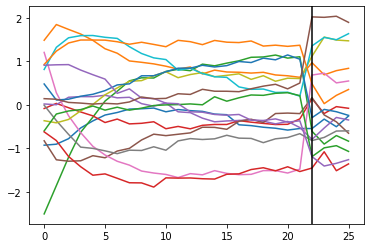

In [295]:
ax = pd.DataFrame(temporal_features[0,:,:]).plot(legend=False)
ax.axvline(x=temporal_hist_selected_vars.shape[1], color="black")

## Static enrichment

This step is responsible for adding static information on the country for which inflation is being nowcasted to the temporal features.

This is achieved by a GRN layer as follows:

$$
\theta(t, n) = \text{GRN}_{\theta}(\tilde{\phi}(t, n), c_e)
$$

In [296]:
def static_enrichment(
    temporal_features:keras.KerasTensor, # $\tilde{\phi}(t, n)$, temporal features of dimension (batch size / num historical + future time steps / embedding size)
    static_context:keras.KerasTensor, # $c_e$, static context enrichment vector of dimensions (batch size / num static vars / embedding size)
    d_model:int, # Embedding size, $d_\text{model}$
    dropout_rate:float=0. # Dropout rate
):
    "Static enrichment"
    enriched, _ = gated_residual_network(
        temporal_features,
        d_model=d_model,
        dropout_rate=dropout_rate,
        use_time_distributed=True,
        additional_context=static_context
    )
    return enriched

In [297]:
show_doc(static_enrichment, title_level=3)

---

### static_enrichment

>      static_enrichment
>                         (temporal_features:keras.src.backend.common.keras_tens
>                         or.KerasTensor, static_context:keras.src.backend.commo
>                         n.keras_tensor.KerasTensor, hidden_layer_size:int,
>                         dropout_rate:float=0.0)

Static enrichment

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| temporal_features | keras.KerasTensor |  | $\tilde{\phi}(t, n)$, temporal features of dimension (batch size / num historical + future time steps / embedding size) |
| static_context | keras.KerasTensor |  | $c_e$, static context enrichment vector of dimensions (batch size / num static vars / embedding size) |
| hidden_layer_size | int |  | Embedding size |
| dropout_rate | float | 0.0 | Dropout rate |

#### Example usage, real data

The code below first creates an static context enrichment vector:

In [298]:
#| code-fold: show

static_context_enrichment, _ = gated_residual_network( # c_3
    x=xi_stat, # Network inputs
    d_model=d_model, # Dimension of the GRN
    output_size=d_model, # Size of output layer (if None, same as `d_model`)
    dropout_rate=0., # Dropout rate
    use_time_distributed=False, # Apply the GRN across all time steps?
)
static_context_enrichment.shape

TensorShape([8, 1, 16])

... and now it is used with the temporal features that are the output of `seq_to_seq` for the static enrichment.

In [299]:
enriched_temporal_features = static_enrichment(
    temporal_features=temporal_features,
    static_context=static_context_enrichment,
    d_model=16
)
temporal_features.shape, enriched_temporal_features.shape

(TensorShape([8, 26, 16]), TensorShape([8, 26, 16]))

## Attention components

* Attention mechanisms use relationships between keys $K \in \mathbf{R}^{N \times d_{attention}}$ and queries $Q \in \mathbf{R}^{N \times d_{attention}}$ to scale a vector of values $V \in \mathbf{R}^{N \times d_V}$: $\text{Attention}(Q, K, V) = A(Q, K) V$
    * $N$ is the number of timesteps going into the attention layer (the number of lags $k$ plus the number of periods to be forecasted $\tau_{\text{max}}$)
    * $A(\cdot)$ is a normalisation function
        * After @vaswani2017attention, the canonical choice for $A(\cdot)$ is the scaled dot-product: $A(Q, K) = \text{Softmax}(\frac{Q K^{T}}{\sqrt{d_{attention}}} )$
    
* The TFT uses a modified attention head to enhance the explainability of the model
* Specifically, the transformer block (multi-head attention) is modified to:
    * share values in each head, and
    * employ additive aggregation of all heads
* More formally, compare the interpretable multi-head attention (used in this paper) with the canonical multi-head attention:
    * $\text{InterpretableMultiHead}(Q, K, V) = \tilde{H} W_{H}$, with:
        * $\begin{aligned}\tilde{H} &= \tilde{A}(Q, K) V W_V \\
        &= \{\frac{1}{m_H} \sum^{m_{H}}_{h=1} A(Q W^{(h)}_Q, K W^{(h)}_K) \} V W_V \\
        &= \frac{1}{m_H} \sum^{m_{H}}_{h=1} \text{Attention}(Q W^{(h)}_Q, K W^{(h)}_K, V W_V)
        \end{aligned}$
    * $\text{MultiHead}(Q, K, V) = [H_1, \dots, H_{m_H}] W_H$, with:
        * $H_h = \text{Attention}(Q W^{(h)}_Q, K W^{(h)}_K, V W_V^{(h)}) $

## Decoder mask for self-attention layer

In [300]:
def get_decoder_mask(
    self_attention_inputs # Inputs to the self-attention layer
):
    "Determines shape of decoder mask"
    len_s = keras.ops.shape(self_attention_inputs)[1] # length of inputs
    bs = keras.ops.shape(self_attention_inputs)[0] # batch shape
    mask = keras.ops.cumsum(keras.ops.eye(len_s), axis=0)

    ### warning: I had to manually implement some batch-wise shape here 
    ### because the new keras `eye` function does not have a batch_size arg.
    ### inspired by: https://github.com/tensorflow/tensorflow/blob/v2.14.0/tensorflow/python/ops/linalg_ops_impl.py#L30
    ### <hack>
    mask = keras.ops.expand_dims(mask, axis=0)    
    mask = keras.ops.tile(mask, (bs, 1, 1))
    ### </hack>

    return mask


In [301]:
#| output: asis
#| echo: false

show_doc(get_decoder_mask, title_level=3)

---

### get_decoder_mask

>      get_decoder_mask (self_attention_inputs)

Determines shape of decoder mask

|    | **Details** |
| -- | ----------- |
| self_attention_inputs | Inputs to the self-attention layer |

#### Example usage

In [302]:
#| code-fold: show

dec = get_decoder_mask(grn)

assert dec.shape == (grn.shape[0], grn.shape[1], grn.shape[1])

Note that it produces an upper-triangular matrix of ones:

In [303]:
#| code-fold: show

dec[0]

<tf.Tensor: shape=(4, 4), dtype=float32, numpy=
array([[1., 0., 0., 0.],
       [1., 1., 0., 0.],
       [1., 1., 1., 0.],
       [1., 1., 1., 1.]], dtype=float32)>

#### Example usage, real data

In [304]:
mask = get_decoder_mask(temporal_features)

print("Mask shape: (batch size / num time seos / num time steps)", mask.shape)

mask[0]

Mask shape: (batch size / num time seos / num time steps) (8, 26, 26)


<tf.Tensor: shape=(26, 26), dtype=float32, numpy=
array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0.,

## Scaled dot product attention layer

* This is the same as Eq. (1) of @vaswani2017attention 
    * except that in this case the dimension of the value vector is the same $d_{\text{attn}} = d_{\text{model}} / m_{\text{Heads}}$ as for the query and key vectors
* As discussed in the paper, additive attention outperforms dot product attention for larger $d_{\text{model}}$ values, so the attention is scaled back to smaller values

In [305]:
class ScaledDotProductAttention(keras.Layer):
    def __init__(
        self,
        attention_dropout:float=0.0 # Will be ignored if `training=False`
    ):
        super().__init__()
        self.dropout = keras.layers.Dropout(rate=attention_dropout)
        self.activation = keras.layers.Activation('softmax')

    def __call__(
        self,
        q, # Queries, tensor of shape (?, time, D_model)
        k, # Keys, tensor of shape (?, time, D_model)
        v, # Values, tensor of shape (?, time, D_model)
        mask, # Masking if required (sets Softmax to very large value), tensor of shape (?, time, time)
        training=None, # Whether the layer is being trained or used in inference
    ):
        # returns Tuple (layer outputs, attention weights)
        scale = keras.ops.sqrt(keras.ops.cast(keras.ops.shape(k)[-1], dtype='float32'))
        attention = layers.Dot(axes=(2, 2))([q, k]) / scale
        #attention = keras.ops.einsum("bij,bjk->bik", q, keras.ops.transpose(k, axes=(0, 2, 1))) / scale
        if mask is not None:
            mmask = keras.layers.Lambda(lambda x: (-1e9) * (1. - keras.ops.cast(x, 'float32')))(mask)
            attention = keras.layers.Add()([attention, mmask])
        attention = self.activation(attention)
        if training:
            attention = self.dropout(attention)
        output = layers.Dot(axes=(2, 1))([attention, v])
        #output = keras.ops.einsum("btt,btd->bt", attention, v)
        return output, attention

In [306]:
#| output: asis
#| echo: false

show_doc(ScaledDotProductAttention, title_level=3)

---

### ScaledDotProductAttention

>      ScaledDotProductAttention (attention_dropout:float=0.0)

This is the class from which all layers inherit.

A layer is a callable object that takes as input one or more tensors and
that outputs one or more tensors. It involves *computation*, defined
in the `call()` method, and a *state* (weight variables). State can be
created:

* in `__init__()`, for instance via `self.add_weight()`;
* in the optional `build()` method, which is invoked by the first
  `__call__()` to the layer, and supplies the shape(s) of the input(s),
  which may not have been known at initialization time.

Layers are recursively composable: If you assign a Layer instance as an
attribute of another Layer, the outer layer will start tracking the weights
created by the inner layer. Nested layers should be instantiated in the
`__init__()` method or `build()` method.

Users will just instantiate a layer and then treat it as a callable.

Args:
    trainable: Boolean, whether the layer's variables should be trainable.
    name: String name of the layer.
    dtype: The dtype of the layer's computations and weights. Can also be a
        `keras.mixed_precision.DTypePolicy`,
        which allows the computation and
        weight dtype to differ. Defaults to `None`. `None` means to use
        `keras.mixed_precision.dtype_policy()`,
        which is a `float32` policy unless set to different value
        (via `keras.mixed_precision.set_dtype_policy()`).

Attributes:
    name: The name of the layer (string).
    dtype: Dtype of the layer's weights. Alias of `layer.variable_dtype`.
    variable_dtype: Dtype of the layer's weights.
    compute_dtype: The dtype of the layer's computations.
        Layers automatically cast inputs to this dtype, which causes
        the computations and output to also be in this dtype.
        When mixed precision is used with a
        `keras.mixed_precision.DTypePolicy`, this will be different
        than `variable_dtype`.
    trainable_weights: List of variables to be included in backprop.
    non_trainable_weights: List of variables that should not be
        included in backprop.
    weights: The concatenation of the lists trainable_weights and
        non_trainable_weights (in this order).
    trainable: Whether the layer should be trained (boolean), i.e.
        whether its potentially-trainable weights should be returned
        as part of `layer.trainable_weights`.
    input_spec: Optional (list of) `InputSpec` object(s) specifying the
        constraints on inputs that can be accepted by the layer.

We recommend that descendants of `Layer` implement the following methods:

* `__init__()`: Defines custom layer attributes, and creates layer weights
    that do not depend on input shapes, using `add_weight()`,
    or other state.
* `build(self, input_shape)`: This method can be used to create weights that
    depend on the shape(s) of the input(s), using `add_weight()`, or other
    state. `__call__()` will automatically build the layer
    (if it has not been built yet) by calling `build()`.
* `call(self, *args, **kwargs)`: Called in `__call__` after making
    sure `build()` has been called. `call()` performs the logic of applying
    the layer to the input arguments.
    Two reserved keyword arguments you can optionally use in `call()` are:
        1. `training` (boolean, whether the call is in inference mode or
            training mode).
        2. `mask` (boolean tensor encoding masked timesteps in the input,
            used e.g. in RNN layers).
    A typical signature for this method is `call(self, inputs)`, and user
    could optionally add `training` and `mask` if the layer need them.
* `get_config(self)`: Returns a dictionary containing the configuration
    used to initialize this layer. If the keys differ from the arguments
    in `__init__()`, then override `from_config(self)` as well.
    This method is used when saving
    the layer or a model that contains this layer.

Examples:

Here's a basic example: a layer with two variables, `w` and `b`,
that returns `y = w . x + b`.
It shows how to implement `build()` and `call()`.
Variables set as attributes of a layer are tracked as weights
of the layers (in `layer.weights`).

```python
class SimpleDense(Layer):
    def __init__(self, units=32):
        super().__init__()
        self.units = units

    # Create the state of the layer (weights)
    def build(self, input_shape):
        self.kernel = self.add_weight(
            shape=(input_shape[-1], self.units),
            initializer="glorot_uniform",
            trainable=True,
            name="kernel",
        )
        self.bias = self.add_weight(
            shape=(self.units,),
            initializer="zeros",
            trainable=True,
            name="bias",
        )

    # Defines the computation
    def call(self, inputs):
        return ops.matmul(inputs, self.kernel) + self.bias

# Instantiates the layer.
linear_layer = SimpleDense(4)

# This will also call `build(input_shape)` and create the weights.
y = linear_layer(ops.ones((2, 2)))
assert len(linear_layer.weights) == 2

# These weights are trainable, so they're listed in `trainable_weights`:
assert len(linear_layer.trainable_weights) == 2
```

Besides trainable weights, updated via backpropagation during training,
layers can also have non-trainable weights. These weights are meant to
be updated manually during `call()`. Here's a example layer that computes
the running sum of its inputs:

```python
class ComputeSum(Layer):

  def __init__(self, input_dim):
      super(ComputeSum, self).__init__()
      # Create a non-trainable weight.
      self.total = self.add_weight(
        shape=(),
        initializer="zeros",
        trainable=False,
        name="total",
      )

  def call(self, inputs):
      self.total.assign(self.total + ops.sum(inputs))
      return self.total

my_sum = ComputeSum(2)
x = ops.ones((2, 2))
y = my_sum(x)

assert my_sum.weights == [my_sum.total]
assert my_sum.non_trainable_weights == [my_sum.total]
assert my_sum.trainable_weights == []
```

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| attention_dropout | float | 0.0 | Will be ignored if `training=False` |

#### Example usage
Below is an example of how the `ScaledDotProductAttention` layer works:

In [307]:
#| code-fold: show

batch_size = 3
n_timesteps = 5
n_features = 13

# input dimensions: batches / timesteps / features
x_btf = np.random.randn(batch_size*n_timesteps*n_features).reshape([batch_size, n_timesteps, n_features]) 

# using the same vector for q, k and v just to simplify
q=keras.ops.cast(x_btf, 'float32')
k=keras.ops.cast(x_btf, 'float32')
v=keras.ops.cast(x_btf, 'float32')

Testing without masking:

In [308]:
#| code-fold: show

output, attention = ScaledDotProductAttention()(q=q, k=k, v=v, mask=None)
output.shape, attention.shape

(TensorShape([3, 5, 13]), TensorShape([3, 5, 5]))

... and with masking:

In [309]:
#| code-fold: show

output, attention = ScaledDotProductAttention()(q=q, k=k, v=v, mask=get_decoder_mask(q))
output[0], attention[0] # both have shape (batch_size, n_timesteps)

(<tf.Tensor: shape=(5, 13), dtype=float32, numpy=
 array([[-0.14776106, -1.0879458 , -0.15730837, -0.494091  , -2.7955859 ,
         -2.6031895 , -0.1912704 ,  0.896574  ,  0.6475475 , -0.48991656,
         -0.74347275,  0.32896933,  1.0238875 ],
        [ 1.4554353 ,  0.46219033,  0.22689417,  0.98617977,  0.12074617,
         -0.79984117, -0.5794376 ,  0.31840843,  0.07546627,  0.8230984 ,
         -0.3148833 ,  0.6332137 ,  1.0505948 ],
        [ 1.9309696 , -0.34816128, -0.20549715, -0.34562284,  0.09046847,
         -0.38782096, -0.9117362 ,  0.5088456 ,  0.13699344,  0.14968392,
         -0.7362113 ,  0.7090293 ,  0.8203615 ],
        [-0.17281032,  1.1261605 ,  0.30720872, -0.62962663, -0.80928034,
         -0.78987753,  1.2697392 , -0.4360406 ,  0.3801062 ,  1.2037032 ,
         -0.6244763 , -0.04262254, -0.01166791],
        [ 0.25452995,  1.0690148 , -0.69128937, -0.03800721, -0.01215954,
         -0.64936614,  0.7102093 , -0.7473217 ,  0.03684461,  0.20051916,
         -0.99

#### Example usage, real data

In [310]:
#| code-fold: show

mask = get_decoder_mask(enriched_temporal_features)

output, attention = ScaledDotProductAttention()(
    q=enriched_temporal_features,
    k=enriched_temporal_features,
    v=enriched_temporal_features,
    mask=mask
)

print("attention shape: (batch size / num time steps / embedding size)", output.shape)
print("attention shape: (batch size / num time steps / num time steps)", attention.shape)

attention shape: (batch size / num time steps / embedding size) (8, 26, 16)
attention shape: (batch size / num time steps / num time steps) (8, 26, 26)


The attention weights for the future periods are shown below.

In [311]:
attention[0,-xi_fut.shape[1]:]

<tf.Tensor: shape=(4, 26), dtype=float32, numpy=
array([[0.03839637, 0.03466336, 0.02927443, 0.02566394, 0.02358755,
        0.01965914, 0.02165086, 0.01901119, 0.0211113 , 0.0215862 ,
        0.01858256, 0.01712308, 0.0200353 , 0.02038929, 0.01990772,
        0.01841873, 0.01698707, 0.01674386, 0.017187  , 0.01765863,
        0.01548308, 0.018598  , 0.5282813 , 0.        , 0.        ,
        0.        ],
       [0.02854961, 0.02317184, 0.01893406, 0.01642064, 0.01489503,
        0.01300766, 0.01427985, 0.01230212, 0.0133055 , 0.01331189,
        0.01214397, 0.01058347, 0.01279168, 0.01252961, 0.01188818,
        0.0111387 , 0.00966663, 0.00937089, 0.01004678, 0.0096926 ,
        0.00897283, 0.01008793, 0.31995025, 0.38295832, 0.        ,
        0.        ],
       [0.01894646, 0.01825989, 0.01694629, 0.01555669, 0.01467506,
        0.01288957, 0.0141046 , 0.01247822, 0.01319274, 0.01325028,
        0.01173665, 0.01028238, 0.01226783, 0.01185675, 0.01119252,
        0.01050412, 0.009

## Softmax

A small detour to illustrate the softmax function. 

The $i^{\text{th}}$ element of $\text{Softmax}(x)$, with $x \in \mathbf{R}^K$ is:

$$
\text{Softmax}(x)_i = \frac{e^{x_i}}{\sum_{j=1}^K e^{x_j}}
$$

For example, see the values below for an input vector $x$ ($K=5$ in this example):

In [312]:
#| code-fold: show

x = np.array([-np.Inf, -1., 0., 1., 3.])
keras.layers.Activation('softmax')(x)
print("x = ", x)
print("exp(x) = ", np.exp(x))
print("denominator (sum of exp(x_j), j=1,...,K) = ", sum(np.exp(x)))
print("softmax(x) = ", np.exp(x) / sum(np.exp(x)))
print("sum of softmax(x)_j, j=1,...,K = ", sum(np.exp(x) / sum(np.exp(x))))

x =  [-inf  -1.   0.   1.   3.]
exp(x) =  [ 0.          0.36787944  1.          2.71828183 20.08553692]
denominator (sum of exp(x_j), j=1,...,K) =  24.171698192818155
softmax(x) =  [0.         0.01521943 0.0413707  0.11245721 0.83095266]
sum of softmax(x)_j, j=1,...,K =  1.0


As can be seen above, the softmax function really makes the largest numbers stand out from the rest.

Note also that $-\infty$ results in 0.

## Interpretable Multi-head attention

* When values are shared in each head and then are aggregated additively, each head can still learn different temporal patterns (from their own unique queries and keys), but with the same input values.
    * In other words, they can be interpreted as an ensemble over the attention weights
    * the paper doesn't mention this explicitly, but the ensemble is equally-weighted - maybe there is some performance to be gained by having some way to weight the different attention heads 🤔, such as having a linear layer combining them... will explore in the future

In [375]:
class InterpretableMultiHeadAttention(keras.Layer):
    def __init__(
        self,
        n_head:int,
        d_model:int, # Embedding size, $d_\text{model}$
        dropout_rate:float, # Will be ignored if `training=False`
    ):
        super().__init__()
        self.n_head = n_head
        self.d_k = self.d_v = d_model // n_head # the original model divides by number of heads
        self.dropout_rate = dropout_rate

        # using the same value layer facilitates interpretability
        vs_layer = keras.layers.Dense(self.d_v, use_bias=False, name="Shared value")

        # creates list of queries, keys and values across heads
        self.qs_layers = self._build_layers(self.d_k, n_head)
        self.ks_layers = self._build_layers(self.d_k, n_head)
        self.vs_layers = [vs_layer for _ in range(n_head)]

        self.attention = ScaledDotProductAttention()
        self.w_o = keras.layers.Dense(self.d_v, use_bias=False, name="W_v") # W_v in Eqs. (14)-(16), output weight matrix to project internal state to the original TFT

    def call(
        self,
        q, # Queries, tensor of shape (?, time, D_model)
        k, # Keys, tensor of shape (?, time, D_model)
        v, # Values, tensor of shape (?, time, D_model)
        mask=None, # Masking if required (sets Softmax to very large value), tensor of shape (?, time, time)
        training=None
    ):
        heads = []
        attns = []
        for i in range(self.n_head):
            qs = self.qs_layers[i](q)
            ks = self.ks_layers[i](q)
            vs = self.vs_layers[i](v)
           
            head, attn = self.attention(qs, ks, vs, mask, training=training)
            if training:
                head = keras.layers.Dropout(self.dropout_rate)(head)
            heads.append(head)
            attns.append(attn)
        head = keras.ops.stack(heads) if self.n_head > 1 else heads[0]

        outputs = keras.ops.mean(heads, axis=0) if self.n_head > 1 else head # H_tilde
        outputs = self.w_o(outputs)
        if training:
            outputs = keras.layers.Dropout(self.dropout_rate)(outputs)

        return outputs, attn

    def _build_layers(self, d:int, n_head:int):
        return [keras.layers.Dense(d) for _ in range(n_head)]

In [314]:
#| output: asis
#| echo: false

show_doc(InterpretableMultiHeadAttention, title_level=3)

---

### InterpretableMultiHeadAttention

>      InterpretableMultiHeadAttention (n_head:int, d_model:int,
>                                       dropout_rate:float)

This is the class from which all layers inherit.

A layer is a callable object that takes as input one or more tensors and
that outputs one or more tensors. It involves *computation*, defined
in the `call()` method, and a *state* (weight variables). State can be
created:

* in `__init__()`, for instance via `self.add_weight()`;
* in the optional `build()` method, which is invoked by the first
  `__call__()` to the layer, and supplies the shape(s) of the input(s),
  which may not have been known at initialization time.

Layers are recursively composable: If you assign a Layer instance as an
attribute of another Layer, the outer layer will start tracking the weights
created by the inner layer. Nested layers should be instantiated in the
`__init__()` method or `build()` method.

Users will just instantiate a layer and then treat it as a callable.

Args:
    trainable: Boolean, whether the layer's variables should be trainable.
    name: String name of the layer.
    dtype: The dtype of the layer's computations and weights. Can also be a
        `keras.mixed_precision.DTypePolicy`,
        which allows the computation and
        weight dtype to differ. Defaults to `None`. `None` means to use
        `keras.mixed_precision.dtype_policy()`,
        which is a `float32` policy unless set to different value
        (via `keras.mixed_precision.set_dtype_policy()`).

Attributes:
    name: The name of the layer (string).
    dtype: Dtype of the layer's weights. Alias of `layer.variable_dtype`.
    variable_dtype: Dtype of the layer's weights.
    compute_dtype: The dtype of the layer's computations.
        Layers automatically cast inputs to this dtype, which causes
        the computations and output to also be in this dtype.
        When mixed precision is used with a
        `keras.mixed_precision.DTypePolicy`, this will be different
        than `variable_dtype`.
    trainable_weights: List of variables to be included in backprop.
    non_trainable_weights: List of variables that should not be
        included in backprop.
    weights: The concatenation of the lists trainable_weights and
        non_trainable_weights (in this order).
    trainable: Whether the layer should be trained (boolean), i.e.
        whether its potentially-trainable weights should be returned
        as part of `layer.trainable_weights`.
    input_spec: Optional (list of) `InputSpec` object(s) specifying the
        constraints on inputs that can be accepted by the layer.

We recommend that descendants of `Layer` implement the following methods:

* `__init__()`: Defines custom layer attributes, and creates layer weights
    that do not depend on input shapes, using `add_weight()`,
    or other state.
* `build(self, input_shape)`: This method can be used to create weights that
    depend on the shape(s) of the input(s), using `add_weight()`, or other
    state. `__call__()` will automatically build the layer
    (if it has not been built yet) by calling `build()`.
* `call(self, *args, **kwargs)`: Called in `__call__` after making
    sure `build()` has been called. `call()` performs the logic of applying
    the layer to the input arguments.
    Two reserved keyword arguments you can optionally use in `call()` are:
        1. `training` (boolean, whether the call is in inference mode or
            training mode).
        2. `mask` (boolean tensor encoding masked timesteps in the input,
            used e.g. in RNN layers).
    A typical signature for this method is `call(self, inputs)`, and user
    could optionally add `training` and `mask` if the layer need them.
* `get_config(self)`: Returns a dictionary containing the configuration
    used to initialize this layer. If the keys differ from the arguments
    in `__init__()`, then override `from_config(self)` as well.
    This method is used when saving
    the layer or a model that contains this layer.

Examples:

Here's a basic example: a layer with two variables, `w` and `b`,
that returns `y = w . x + b`.
It shows how to implement `build()` and `call()`.
Variables set as attributes of a layer are tracked as weights
of the layers (in `layer.weights`).

```python
class SimpleDense(Layer):
    def __init__(self, units=32):
        super().__init__()
        self.units = units

    # Create the state of the layer (weights)
    def build(self, input_shape):
        self.kernel = self.add_weight(
            shape=(input_shape[-1], self.units),
            initializer="glorot_uniform",
            trainable=True,
            name="kernel",
        )
        self.bias = self.add_weight(
            shape=(self.units,),
            initializer="zeros",
            trainable=True,
            name="bias",
        )

    # Defines the computation
    def call(self, inputs):
        return ops.matmul(inputs, self.kernel) + self.bias

# Instantiates the layer.
linear_layer = SimpleDense(4)

# This will also call `build(input_shape)` and create the weights.
y = linear_layer(ops.ones((2, 2)))
assert len(linear_layer.weights) == 2

# These weights are trainable, so they're listed in `trainable_weights`:
assert len(linear_layer.trainable_weights) == 2
```

Besides trainable weights, updated via backpropagation during training,
layers can also have non-trainable weights. These weights are meant to
be updated manually during `call()`. Here's a example layer that computes
the running sum of its inputs:

```python
class ComputeSum(Layer):

  def __init__(self, input_dim):
      super(ComputeSum, self).__init__()
      # Create a non-trainable weight.
      self.total = self.add_weight(
        shape=(),
        initializer="zeros",
        trainable=False,
        name="total",
      )

  def call(self, inputs):
      self.total.assign(self.total + ops.sum(inputs))
      return self.total

my_sum = ComputeSum(2)
x = ops.ones((2, 2))
y = my_sum(x)

assert my_sum.weights == [my_sum.total]
assert my_sum.non_trainable_weights == [my_sum.total]
assert my_sum.trainable_weights == []
```

|    | **Type** | **Details** |
| -- | -------- | ----------- |
| n_head | int |  |
| d_model | int |  |
| dropout_rate | float | Will be ignored if `training=False` |

#### Example usage

In [315]:
#| code-fold: show

imha = InterpretableMultiHeadAttention(n_head=8, d_model=16, dropout_rate=0.)

In [316]:
#| code-fold: show

grn.shape # B, T, F

TensorShape([8, 4, 16])

In [317]:
#| code-fold: show

mask = get_decoder_mask(grn)
mask.shape # shape (batch size / num time steps / num time steps)

TensorShape([8, 4, 4])

In [318]:
#| code-fold: show

output, attn = imha(grn, grn, grn, mask)
output.shape, attn.shape

(TensorShape([8, 4, 2]), TensorShape([8, 4, 4]))

#### Exampel usage, real data

In [319]:
#| code-fold: show

mask = get_decoder_mask(enriched_temporal_features)

output, attention = InterpretableMultiHeadAttention(
    n_head=1,
    d_model=16,
    dropout_rate=0.
)(
    q=enriched_temporal_features,
    k=enriched_temporal_features,
    v=enriched_temporal_features,
    mask=mask
)

print("attention shape: (batch size / num time steps / embedding size)", output.shape)
print("attention shape: (batch size / num time steps / num time steps)", attention.shape)

attention shape: (batch size / num time steps / embedding size) (8, 26, 16)
attention shape: (batch size / num time steps / num time steps) (8, 26, 26)


## Putting it all together: TFT

In [323]:
###

class PartialTFT(keras.Model):
    def __init__(
        self,
        d_model:int=16, # Embedding size, $d_\text{model}$
        output_size:int=1
    ):
        super().__init__()
        self.d_model = d_model
        self.output_size = output_size
        
        self.input_layer = InputTFT(
            d_model=self.d_model,
            name="Input"
        )
        
        self.flat = layers.Flatten()
        self.concat = layers.Concatenate(axis=-1)
        self.dense_hidden = layers.Dense(self.d_model)
        self.dense_output = layers.Dense(self.output_size)
    
    def call(
        self,
        input:list # List with [continuous historical, categorical historical, categorical static, categorical future data]
    ):
        cont_hist, cat_hist, cat_stat, cat_fut = input
        if len(cat_stat.shape) == 2:
            cat_stat = keras.ops.expand_dims(cat_stat, axis=-1)

        hist, cat_stat, fut = self.input_layer([cont_hist, cat_hist, cat_stat, cat_fut])

        hist = self.flat(hist)
        cat_stat = self.flat(cat_stat)
        fut = self.flat(fut)

        output = self.concat([hist, cat_stat, fut])

        output = self.dense_hidden(output)
        output = self.dense_output(output)
        return output

model = PartialTFT(output_size=batch_y.shape[-1])
model.compile(optimizer="rmsprop", loss="mse")
model.fit([batch_cont_hist, batch_cat_hist, batch_cat_stat, batch_cat_fut], batch_y, epochs=5)

Epoch 1/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - loss: 0.4339
Epoch 2/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 174.0098
Epoch 3/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 31.7995
Epoch 4/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - loss: 51.1069
Epoch 5/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 113.7482


In [376]:
class TemporalFusionTransformer(keras.Model):
    def __init__(
        self,
        quantiles=[0.05, 0.25, 0.5, 0.75, 0.95],
        d_model:int=16, # Embedding size, $d_\text{model}$
        output_size:int=1, # How many periods to nowcast/forecast?
        n_head:int=4,
        dropout_rate:float=0.1,
        random_state:int=1985,
        **kwargs
    ):
        super().__init__(**kwargs)
        self.quantiles = quantiles
        self.d_model = d_model
        self.output_size = output_size
        self.n_head = n_head
        self.dropout_rate = dropout_rate
        self.random_state = random_state

        keras.utils.set_random_seed(self.random_state)

        self.input_layer = InputTFT(
            d_model=self.d_model,
            output_size=self.output_size
        )
        self.self_attention = InterpretableMultiHeadAttention(
            n_head=self.n_head,
            d_model=self.d_model,
            dropout_rate=self.dropout_rate
        )

        output_len = self.output_size * len(self.quantiles)
        self.output_layer = layers.TimeDistributed(
            layers.Dense(output_len)
        )

    def call(
        self,
        inputs,
        training=None
    ):
        "Creates the model architecture"

        # embedding the inputs
        cont_hist, cat_hist, cat_stat, cat_fut = inputs
        if len(cat_stat.shape) == 2:
            cat_stat = keras.ops.expand_dims(cat_stat, axis=-1)
            
        hist, cat_stat, fut = self.input_layer([cont_hist, cat_hist, cat_stat, cat_fut])

        # selecing the static covariates
        static_selected_vars, static_selection_weights = static_variable_selection(
            xi_stat, 
            d_model=d_model, 
            dropout_rate=0.
        )

        # create context vectors from static data
        static_context_variable_selection, _ = gated_residual_network(
            static_selected_vars,
            self.d_model,
            dropout_rate=self.dropout_rate,
            use_time_distributed=False
        )
        
        static_context_enrichment, _ = gated_residual_network(
            static_selected_vars,
            self.d_model,
            dropout_rate=self.dropout_rate,
            use_time_distributed=False
        )

        static_context_state_h, _ = gated_residual_network(
            static_selected_vars,
            self.d_model,
            dropout_rate=self.dropout_rate,
            use_time_distributed=False
        )

        static_context_state_c, _ = gated_residual_network(
            static_selected_vars,
            self.d_model,
            dropout_rate=self.dropout_rate,
            use_time_distributed=False
        )

        # temporal variable selection
        temporal_hist_selected_vars, temporal_hist_selection_weights = temporal_variable_selection(
            embedding=xi_hist,
            context=static_context_variable_selection,
            d_model=d_model, 
            dropout_rate=0.
        )

        temporal_fut_selected_vars, temporal_fut_selection_weights = temporal_variable_selection(
            embedding=xi_fut,
            context=static_context_variable_selection,
            d_model=d_model, 
            dropout_rate=self.dropout_rate
        )

        # sequence-to-sequence encoding
        temporal_features = seq_to_seq(
            d_model=self.d_model,
            dropout_rate=self.dropout_rate,
            historical_features=temporal_hist_selected_vars,
            future_features=temporal_fut_selected_vars,
            static_context_state_h=static_context_state_h,
            static_context_state_c=static_context_state_c
        )

        # static enrichment
        expanded_context = keras.ops.expand_dims(
            static_context_enrichment,
            axis=1
        )

        enriched_temporal_features = static_enrichment(
            temporal_features=temporal_features,
            static_context=expanded_context,
            d_model=self.d_model
        )

        mask = get_decoder_mask(enriched_temporal_features)

        features, self.attn_ = self.self_attention(
            q=enriched_temporal_features,
            k=enriched_temporal_features,
            v=enriched_temporal_features,
            mask=mask,
            training=training
        )

        # compare pre-attention features with post
        features, _ = apply_gating_layer(
            features,
            self.d_model,
            dropout_rate=self.dropout_rate,
            activation=None
        )
        features = add_and_norm([features, enriched_temporal_features])

        # non-linear processing of self-attention output
        decoder, _ = gated_residual_network(
            features,
            d_model=self.d_model,
            dropout_rate=self.dropout_rate,
            use_time_distributed=True
        )

        # final skip connection
        decoder, _ = apply_gating_layer(
            decoder, 
            self.d_model, 
            activation=None
        )
        transformer_layer = add_and_norm([decoder, temporal_features])

        # define the outputs
        return self.output_layer(
            transformer_layer[:,xi_hist.shape[1]:,:]
        )

In [364]:
cont_hist, cat_hist, stat, fut, y = batch_breakdown(batch)

tft = TemporalFusionTransformer(output_size=3)
output = tft([cont_hist, cat_hist, stat, fut])

/Users/douglasaraujo/Coding/.venv_gingado/lib/python3.10/site-packages/keras/src/layers/layer.py:358: UserWarning: `build()` was called on layer 'input_tft_22', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/Users/douglasaraujo/Coding/.venv_gingado/lib/python3.10/site-packages/keras/src/layers/layer.py:1217: UserWarning: Layer 'temporal_fusion_transformer_14' looks like it has unbuilt state, but Keras is not able to trace the layer `call()` in order to build it automatically. Possible causes:
1. The `call()` method of your layer may be crashing. Try to `__call__()` the layer eagerly on some test input first to see if it works. E.g. `x = np.random.random((3, 4)); y = layer(x)`
2. If the `call()` method is correct, then you may need to implement

In [373]:
#| code-fold: show

cont_hist, cat_hist, stat, fut, y = batch_breakdown(batch)

tft = TemporalFusionTransformer(output_size=3)
tft.compile(optimizer="rmsprop", loss="mse")
output = tft.fit([cont_hist, cat_hist, stat, fut], y)

/Users/douglasaraujo/Coding/.venv_gingado/lib/python3.10/site-packages/keras/src/layers/layer.py:358: UserWarning: `build()` was called on layer 'input_tft_24', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/Users/douglasaraujo/Coding/.venv_gingado/lib/python3.10/site-packages/keras/src/layers/layer.py:1217: UserWarning: Layer 'temporal_fusion_transformer_16' looks like it has unbuilt state, but Keras is not able to trace the layer `call()` in order to build it automatically. Possible causes:
1. The `call()` method of your layer may be crashing. Try to `__call__()` the layer eagerly on some test input first to see if it works. E.g. `x = np.random.random((3, 4)); y = layer(x)`
2. If the `call()` method is correct, then you may need to implement

ValueError: Exception encountered when calling TimeDistributed.call().

[1mInvalid dtype: NoneType[0m

Arguments received by TimeDistributed.call():
  • inputs=tf.Tensor(shape=(8, None, 16), dtype=float32)
  • training=True
  • mask=None

In [372]:
print(tft.summary())

Model: "temporal_fusion_transformer_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ input_tft_23 (InputTFT)         │ ?                         │     24,320 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ interpretable_multi_head_atten… │ ?                         │          0 │
│ (InterpretableMultiHeadAttenti… │                           │  (unbuilt) │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ time_distributed_33479          │ ?                         │          0 │
│ (TimeDistributed)               │                           │  (unbuilt) │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 24,320 (95.00 KB)

 Trainable params: 24,320 (95.00 KB)

 Non-trainable params: 0 (0.00 B)

None


___

In [90]:
class TemporalFusionTransformer():
    def __init__(
        self,
        # Data params
        time_steps:int,
        input_size:int,
        output_size:int,
        category_counts:int,
        n_workers:int, # Number of multiprocessing workers

        # TFT params
        input_obs_loc,
        static_input_loc,
        known_regular_input_idx,
        known_categorical_input_idx,
        column_definition,

        # Network params
        quantile:list=[0.1, 0.5, 0.9], # List of quantiles the model should forecast
        d_model:int=30, # Embedding size, $d_\text{model}$
        dropout_rate:float=0.0, # Dropout ratio (between 0.0, inclusive, and less than 1.0)
        num_encoder_steps:int=4,
        num_stacks:int=4,
        num_heads:int=4,
        
        # Training params
        max_gradient_norm:float=1.0, # 
        learning_rate:float=0.001,
        minibatch_size:int=64,
        num_epochs:int=100,
        early_stopping_patience:int=5,
        use_gpu:bool=True
    ):
        self.time_steps = time_steps
        self.input_size = input_size
        self.output_size = output_size # Number of periods to be forecasted
        self.category_counts = category_counts
        self.n_workers = n_workers # Number of multiprocessing workers
        
        self.input_obs_loc = input_obs_loc
        self.static_input_loc = static_input_loc
        self.known_regular_input_idx = known_regular_input_idx
        self.known_categorical_input_idx = known_categorical_input_idx
        self.column_definition = column_definition

        self.quantile = quantile # List of quantiles the model should forecast
        self.d_model = d_model # Size of hidden layer
        self.dropout_rate = dropout_rate # Dropout ratio (between 0.0, inclusive, and less than 1.0)
        self.num_encoder_steps = num_encoder_steps
        self.num_stacks = num_stacks
        self.num_heads = num_heads
        
        self.max_gradient_norm = max_gradient_norm
        self.learning_rate = learning_rate
        self.minibatch_size = minibatch_size
        self.num_epochs = num_epochs
        self.early_stopping_patience = early_stopping_patience
        self.use_gpu = use_gpu

        self.model = self.build_model()

    def __get_tft_embeddings(
        self,
        all_inputs # Input tensor of dimensions (batch, time steps, num variables)
    ):
        # Transform raw inputs to embeddings
        # For continuous variables: linear transformation
        # For categorical variables: embeddings
        
        num_categorical_variables = len(self.category_counts)
        num_regular_variables = self.input_size - num_categorical_variables

        embedding_sizes = [
            self.d_model
            for i, size in enumerate(self.category_counts)
        ]

        embeddings = [
            keras.Sequential([
                layers.InputLayer([self.time_steps]),
                layers.Embedding(
                    self.category_counts[i],
                    embedding_sizes[i],
                    input_length=self.time_steps,
                    dtype='float32'
                )
            ])
            for i in range(num_categorical_variables)
        ]

        regular_inputs, categorical_inputs = \
            all_inputs[:, :, :num_regular_variables], \
            all_inputs[:, :, num_regular_variables:]

        embedded_inputs = [
            embeddings[i](categorical_inputs[Ellipsis, i])
            for i in range(num_categorical_variables)
        ]

        # static inputs
        if self._static_input_loc:
            st_inp_dense = [
                layers.Dense(self.d_model)(
                    regular_inputs[:, 0, i:i + 1]
                )
                for i in range(num_regular_variables)
                if i in self._static_input_loc
            ]
            st_inp_embed = [
                embedded_inputs[i][:, 0, :]
                for i in range(num_categorical_variables)
                if  i + num_regular_variables in self._static_input_loc
            ]
            static_inputs = st_inp_dense + st_inp_embed
        else:
            static_inputs = None

        # Targets
        past_inputs = keras.ops.stack([
            dense_layer(
                size=self.d_model,
                activation=None,
                use_time_distributed=True
            )(regular_inputs[Ellipsis, i:i + 1])
        ], axis=-1)

        # past inputs: observed but not known a priori
        wired_embeddings = [
            embeddings[i](categorical_inputs[:,:,i])
            for i in range(num_categorical_variables)
            if i not in self._known_categorical_input_idx \
                and i + num_regular_variables not in self._input_obs_loc    
        ]
        unknown_inputs = [
            dense_layer(
                size=self.d_model,
                activation=None,
                use_time_distributed=True
            )(regular_inputs[Ellipsis, i:i + 1])
            for i in range(regular_inputs.shape[-1])
            if i not in self._known_categorical_input_idx \
                and i + num_regular_variables not in self._input_obs_loc    
        ]
        if wired_embeddings + unknown_inputs:
            unknown_inputs = keras.ops.stack(wired_embeddings + unknown_inputs, axis=-1)
        else:
            unkown_inputs = None

        # a priori known inputs
        known_regular_inputs = [
            dense_layer(
                size=self.d_model,
                activation=None,
                use_time_distributed=True
            )(regular_inputs[Ellipsis, i:i + 1])
            for i in self._known_regular_input_idx
            if i not in self._static_input_loc
        ]
        known_categorical_inputs = [
            embedded_inputs[i]
            for i in self._known_categorical_input_idx
            if i + num_regular_variables not in self._static_input_loc
        ]
        known_combined_layer = keras.ops.stack(
            known_regular_inputs + known_categorical_inputs,
            axis=-1
        )

        return unknown_inputs, known_combined_layer, past_inputs, static_inputs

    def _build_base_graph(self):
        # Build the graph, defining the layers of the TFT
        

        ### <TFTInputs>
        all_inputs = layers.Input(
            shape=(self.time_steps, self.input_size) # Argument `shape` does not include batch size
        )
        unknown_inputs, known_combined_layer, past_inputs, static_inputs \
            = self.__get_tft_embeddings(all_inputs)
        ### </TFTInputs>

        # first we isolate the known future inputs and observed past inputs
        if unknown_inputs is not None:
            historical_inputs = keras.ops.concatenate([
                unknown_inputs[:, :self.num_encoder_steps, :],
                known_combined_layer[:, :self.num_encoder_steps, :],
                past_inputs[:, :self.num_encoder_steps, :]
            ], axis=1)
        else:
            historical_inputs = keras.ops.concatenate([
                known_combined_layer[:, :self.num_encoder_steps, :],
                past_inputs[:, :self.num_encoder_steps, :]
            ])
        
        # and then we isolate the known future inputs
        future_inputs = known_combined_layer[:, :self.num_encoder_steps, :]

        # static vars
        static_encoder, static_weights = static_variable_selection(static_inputs)

        # Static covariate encoders
        # These integrate static features into the network through encoding of context vectors
        # that condition the time-varying dynamics
        self.static_context_variable_selection = gated_residual_network( # c_s
            x=static_encoder, # Network inputs
            d_model=self.d_model, # Dimension of the GRN
            output_size=self.d_model, # Size of output layer (if None, same as `d_model`)
            dropout_rate=self.dropout_rate, # Dropout rate
            use_time_distributed=False, # Apply the GRN across all time steps?
        )
        self.static_context_enrichment = gated_residual_network( # c_3
            x=static_encoder, # Network inputs
            d_model=self.d_model, # Dimension of the GRN
            output_size=self.d_model, # Size of output layer (if None, same as `d_model`)
            dropout_rate=self.dropout_rate, # Dropout rate
            use_time_distributed=False, # Apply the GRN across all time steps?
        )
        self.static_context_state_h = gated_residual_network( # c_h
            x=static_encoder, # Network inputs
            d_model=self.d_model, # Dimension of the GRN
            output_size=self.d_model, # Size of output layer (if None, same as `d_model`)
            dropout_rate=self.dropout_rate, # Dropout rate
            use_time_distributed=False, # Apply the GRN across all time steps?
        )
        self.static_context_state_c = gated_residual_network( # c_c
            x=static_encoder, # Network inputs
            d_model=self.d_model, # Dimension of the GRN
            output_size=self.d_model, # Size of output layer (if None, same as `d_model`)
            dropout_rate=self.dropout_rate, # Dropout rate
            use_time_distributed=False, # Apply the GRN across all time steps?
        )

        historical_features, historical_flags, _ = temporal_variable_selection(
            embedding=historical_inputs,
            context=self.static_context_variable_selection,
            d_model=self.d_model,
            dropout_rate=self.dropout_rate)
        future_features, future_flags, _ = temporal_variable_selection(
            embedding=future_inputs,
            context=self.static_context_variable_selection,
            d_model=self.d_model,
            dropout_rate=self.dropout_rate)

        # Locality enhancement (Section 4.5.1 in paper) with seq-to-seq layer

        temporal_feature_layer = seq_to_seq(
            d_model=self.d_model,
            dropout_rate=self.dropout_rate,
            historical_features=historical_features,
            future_features=future_features,
            static_context_state_c=self.static_context_state_c,
            static_context_state_h=self.static_context_state_h
        )
        # Temporal Fusion Decoder (TFT, Purple box in Fig. 2)
        # contains three steps
        # TFT 1st step: Static enrichment
        #   - enhances the temporal features with static metadata (Eq. 18)
        
        expanded_static_context_c_e = keras.ops.expand_dims(
            self.static_context_enrichment,
            axis=1
        )
        enriched = gated_residual_network( # $\theta(t, n) = \text{GRN}_{\theta}(\tilde{\theta}(t, n), c_e)
            x=temporal_feature_layer, # from t-k to t+\tau_max
            d_model=self.d_model,
            output_size=self.d_model,
            dropout_rate=self.dropout_rate,
            use_time_distributed=True,
            additional_context=expanded_static_context_c_e,
            return_gate=False
        )

        # TFT 2nd step: Temporal self-attention

        self_attention_layer = InterpretableMultiHeadAttention(
            n_head=self.num_heads,
            d_model=self.d_model,
            dropout=self.dropout_rate # Will be ignored if `training=False`
        )
        mask = get_decoder_mask(enriched)
        post_attn, self_attention = self_attention_layer( # $B(t) = \text{IMHA}(\Theta(t), \Theta(t), \Theta(t))$
            q=enriched,
            k=enriched,
            v=enriched,
            mask=mask
        )
        post_attn, _ = apply_gating_layer( # $\text{GLU}_{\delta}(\beta(t, n))$
            x=post_attn, # Input tensors (batch first)
            d_model=self.d_model, # Dimension of the GLU
            dropout_rate=self.dropout_rate, # Dropout rate
            use_time_distributed=True, # Apply the GLU across all time steps?
            activation=None # Activation function
        )

        # skip connection: decides how much of the attention layer is used
        post_attn = add_and_norm([post_attn, enriched]) # \delta(t, n) = \text{LayerNorm}(\theta(t, n) + $\text{GLU}_{\delta}(\beta(t, n)))$

        # TFT 3rd step: Position-wise feed-forward
        decoder = gated_residual_network(
            x=post_attn,
            d_model=self.d_model,
            output_size=self.d_model,
            dropout_rate=self.dropout_rate,
            use_time_distributed=True,
            additional_context=None,
            return_gate=False
        )

        # final skip connection
        decoder, _ = apply_gating_layer(
            x=decoder, # Input tensors (batch first)
            d_model=self.d_model, # Dimension of the GLU
            dropout_rate=self.dropout_rate, # Dropout rate
            activation=None # Activation function
        )
        # the temporal feature layer here is to help the model decide
        # how much to skip the Temporal Fusion Decoder altogether
        transformer_layer = add_and_norm([decoder, temporal_feature_layer])

        # the function also returns the attention components
        # for explainability analyses
        attention_components = {
            "temporal_attention_weights": self_attention,
            "variable_selection_weights_static_inputs": static_weights[Ellipsis, 0],
            "variable_selection_weights_past_inputs": historical_flags[Ellipsis, 0, :],
            "variable_selection_weights_future_inputs": future_flags[Ellipsis, 0, :]
        }

        return transformer_layer, all_inputs, attention_components

    def build_model(self):
        # Build model and define training losses

        transformer_layer, all_inputs, self._attention_components = self._build_base_graph()
        outputs = keras.layers.TimeDistributed(
            keras.layers.Dense(self.output_size * len(self.quantiles))
        )(transformer_layer[Ellipsis, self.num_encoder_steps:, :])
        model = keras.Model(inputs=all_inputs, outputs=outputs)

# Using the TFT model

## Data

In this example, we will use a simple inflation panel dataset.

In [51]:
from gingado.utils import list_all_dataflows, load_SDMX_data

In [52]:
# dflows = list_all_dataflows()
# dflows[dflows == 'BIS long consumer prices']

In [53]:
df_cpi = load_SDMX_data(
    sources={'BIS': 'WS_LONG_CPI'},
    keys={'FREQ': 'M'},
    params={'startPeriod': 2002}
)

Querying data from BIS's dataflow 'WS_LONG_CPI' - BIS long consumer prices...


In [54]:
df_cpi = df_cpi['2002-01-01':'2023-09-01']
cpi_cols = df_cpi.dropna(how='all', axis=1).columns

In [55]:
# keep only one observation per country, retaining only the ones ending in 628 (in opposition to 771)
df_infl = df_cpi[[c for c in cpi_cols if '628' in c and c != 'BIS__WS_LONG_CPI_M__AE__628']].pct_change(periods=1).dropna(how='all')

Clean the titles from the metadata

In [56]:
df_infl.columns = [c.split('__')[2] for c in df_infl.columns]

<AxesSubplot:xlabel='TIME_PERIOD'>

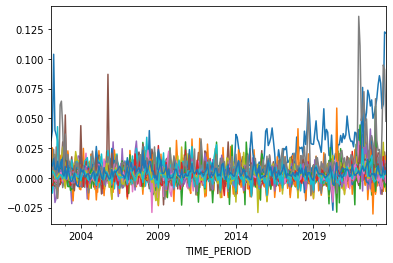

In [57]:
df_infl.plot(legend=False)

In [58]:
train_cutoff = '2013-01-01'
valid_cutoff = '2020-01-01'
df_infl_train, df_infl_valid, df_infl_test = df_infl[:train_cutoff], df_infl[train_cutoff:valid_cutoff], df_infl[valid_cutoff:]
df_infl_train = df_infl_train[:-1]
df_infl_valid = df_infl_valid[:-1]

In [59]:
df_infl_valid

,AR,AT,AU,BE,BG,BR,CA,CH,CL,CN,...,SA,SE,SG,SI,SK,TH,TR,US,XM,ZA
TIME_PERIOD,,,,,,,,,,,,,,,,,,,,,
2013-01-01,0.011371,-0.004469,0.003922,-0.000302,0.004121,0.0086,0.000825,-0.002611,0.003548,0.010002,...,0.010963,-0.008296,0.001889,-0.008048,0.006035,0.001570,0.016461,0.002957,-0.010392,0.001548
2013-02-01,0.004931,0.002245,0.000000,0.003220,0.000504,0.0060,0.011542,0.002955,0.001187,0.010999,...,0.000863,0.004455,0.010049,0.008114,-0.000245,0.002194,0.002999,0.008190,0.003670,0.010819
2013-03-01,0.007262,0.007839,0.000000,0.001404,-0.005390,0.0047,0.001630,0.002172,0.005572,-0.009005,...,-0.000216,0.004021,-0.005378,0.003018,0.000585,0.000626,0.006624,0.002615,0.011784,0.012233
2013-04-01,0.007275,0.001111,0.003906,-0.000401,-0.004348,0.0055,-0.001627,0.000336,-0.001756,0.002002,...,0.000000,-0.001970,-0.014831,0.007021,0.000362,0.001563,0.004204,-0.001040,-0.000904,0.003021
2013-05-01,0.006900,0.002220,0.000000,0.001503,-0.001421,0.0037,0.002445,0.001100,-0.000532,-0.006002,...,-0.000108,0.001624,0.003553,0.002988,0.001026,0.002497,0.001456,0.001780,0.001105,-0.001506
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-08-01,0.038697,0.001017,0.000000,-0.000184,0.000682,0.0011,-0.001460,-0.000102,0.001855,0.007004,...,0.001940,-0.004199,0.006246,0.003708,0.002069,-0.001894,0.008587,-0.000051,0.001430,0.003304
2019-09-01,0.058082,0.004065,0.000000,-0.004590,-0.003423,-0.0004,-0.004386,-0.001096,0.000097,0.008996,...,0.002343,0.004665,-0.000619,-0.001894,0.001304,0.000899,0.009933,0.000783,0.002189,0.002195
2019-10-01,0.031973,0.003036,0.006932,0.003596,0.008009,0.0010,0.002937,-0.002249,0.008185,0.009000,...,0.000508,0.000268,-0.002167,0.000664,-0.000954,-0.001496,0.020022,0.002286,0.001425,0.000000


### Data preparation

This crucial step involves:
* measuring the mean and standard deviation of the inflation of each country in the training dataset
* using the values above to standardise the training, validation and testing datasets

In [60]:
train_scale = {
    'mean': df_infl_train.mean(axis=0),
    'std': df_infl_train.std(axis=0)
}

In [61]:
def normalise_df(df, scale=train_scale):
    norm_dfs = []
    for cty in df.columns.tolist():
        norm_dfs.append((df[cty] - scale['mean'][cty]) / scale['std'][cty])
    return pd.concat(norm_dfs, axis=1)

In [62]:
def renormalise_df(df, scale=train_scale):
    renorm_dfs = []
    for cty in df.columns.tolist():
        renorm_dfs.append((df[cty] * scale['std'][cty]) + scale['mean'][cty])
    return pd.concat(renorm_dfs, axis=1)

In [63]:
# the code below check that it is working:
# (renormalise_df(normalise_df(df_infl_train, train_scale)) - df_infl_train)

In [64]:
df_infl_train_n = normalise_df(df_infl_train)
df_infl_valid_n = normalise_df(df_infl_valid)
df_infl_test_n = normalise_df(df_infl_test)

<AxesSubplot:xlabel='TIME_PERIOD'>

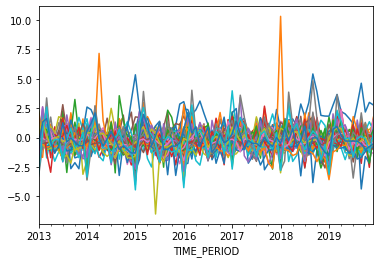

In [65]:
df_infl_valid_n.plot(legend=False)

## A simple dense layer

This first model is autoregressive: it takes in $p$ lags of an inflation series $\pi_i$ (in other words, $\pi_{i, t-p}, ..., \pi_{i, t-1}$) to predict the period $\pi_{i,t}$.

Note that the model is very simple:
* each country's inflation series is only predicted by its past values
* the fully connected linear layer learns to pick up any meaningful non-linear interactions between lags, but there is no intrinsic meaning in the order of the lags
* this network will always take in as input a $p$-sized vector of lagged data

### Data formatting

Let's create a simple function that will take a data frame and return a (input, output) tuple for the model.

In [66]:
def dense_layer_io(
    df, # Pandas DataFrame with the data
    idx:[Int], # DataFrame indedx
    col:[str], # Column name
    p:Int # Number of lags
):
    # Return an (input, output) tuple for a dense_layer model
    
    assert len(idx) == len(col)

    batch_X, batch_y = [], []
    for i in range(len(idx)):
        X = df.iloc[idx[i]:(idx[i]+p)][[col[i]]].values.reshape(-1)
        if np.isnan(X).any():
            continue
        batch_X.append(X)
        batch_y.append(df.iloc[idx[i]+p][[col[i]]].values)
    
    return np.vstack(batch_X), np.vstack(batch_y)

    #return df.iloc[idx:(idx+p)][[col]].values.reshape(-1), df.iloc[idx+p+1][[col]].values

In [67]:
dense_layer_io(df=df_infl_train, idx=[3, 4, 5], col=['BR', 'BR', 'BR'], p=4)

(array([[0.00209779, 0.00419757, 0.01190234, 0.00649815],
        [0.00419757, 0.01190234, 0.00649815, 0.00719811],
        [0.01190234, 0.00649815, 0.00719811, 0.01310222]]),
 array([[0.00719811],
        [0.01310222],
        [0.03020224]]))

In [68]:
def random_select(df, p, n_samples):
    max_index = len(df) - p
    rand_idx, rand_col = [], []
    for _ in range(n_samples):
        rand_idx.append(random.randint(0, max_index-2)) # instead of -1 only, we also need to account for the target value
        rand_col.append(random.choice(df.columns))
    return rand_idx, rand_col

In [69]:
n_samples = 1000 # with replacement

In [70]:
p = 24

idx, col = random_select(df_infl_train_n, p=p, n_samples=n_samples)
train_samples = dense_layer_io(df=df_infl_train_n, idx=idx, col=col, p=p)

idx, col = random_select(df_infl_valid_n, p=p, n_samples=n_samples)
valid_samples = dense_layer_io(df=df_infl_valid_n, idx=idx, col=col, p=p)

### Model

In [71]:
#nn_linear = dense_layer(size=p)

nn_linear = keras.Sequential([
    layers.Input((p,)),
    layers.Dense(32, activation='relu'),
    layers.Dense(5, activation='relu'),
    layers.Dense(1)
])

In [72]:
nn_linear.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ dense_72 (Dense)                │ (None, 32)                │        800 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_73 (Dense)                │ (None, 5)                 │        165 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_74 (Dense)                │ (None, 1)                 │          6 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 971 (3.79 KB)

 Trainable params: 971 (3.79 KB)

 Non-trainable params: 0 (0.00 B)

In [73]:
nn_linear.layers[0].get_weights()

[array([[-3.36906016e-02, -2.88324773e-01, -2.84295440e-01,
          2.31350482e-01, -3.20674628e-01, -1.83200002e-01,
         -1.95912763e-01, -7.73634017e-02, -2.85202980e-01,
         -1.55477569e-01,  3.32024693e-02, -1.44766390e-01,
          2.23105848e-01, -2.07514614e-01,  1.08735025e-01,
          3.08961987e-01, -7.22835660e-02, -2.22998381e-01,
         -2.91681319e-01, -1.17042854e-01, -1.81359798e-01,
          2.41613448e-01,  8.85717869e-02,  2.45229602e-01,
          1.63039237e-01, -2.43400902e-01, -2.63005853e-01,
          2.15264857e-01, -2.30350137e-01, -1.22503296e-01,
         -5.46252131e-02, -2.35365748e-01],
        [ 1.49490029e-01,  2.23501921e-01,  2.71095991e-01,
          6.57997727e-02,  1.80384755e-01,  2.44235754e-01,
          2.07131445e-01, -1.69277489e-02,  2.77400017e-01,
         -3.16308737e-02,  2.97998846e-01,  2.85730064e-01,
          9.21469033e-02, -1.84848845e-01,  2.45206833e-01,
         -2.45289177e-01, -9.04566944e-02, -2.62988836e-

In [74]:
nn_linear.layers[1].get_weights()

[array([[ 0.15292168, -0.16990212,  0.1281966 ,  0.27158642, -0.03940159],
        [-0.15453587,  0.2788571 ,  0.2552446 ,  0.25929612, -0.00359258],
        [-0.04698193, -0.20610996, -0.06019381,  0.28337908,  0.24271864],
        [-0.0391607 ,  0.08948445, -0.13492781, -0.12533885,  0.2997132 ],
        [-0.23169163,  0.36373395,  0.34082317,  0.26588422,  0.26191086],
        [-0.36926153, -0.01567453,  0.0540325 ,  0.17088872, -0.01088232],
        [ 0.1419006 ,  0.32993674,  0.33136892, -0.30035973, -0.2816222 ],
        [-0.13628483,  0.05728358,  0.37226915, -0.06942928,  0.05167452],
        [-0.10657454, -0.21881884,  0.18417943, -0.07534087,  0.00190434],
        [ 0.3011253 ,  0.20400947,  0.16668934,  0.03312525, -0.04623201],
        [-0.4018473 , -0.10559717, -0.07911232, -0.12266144, -0.10475075],
        [ 0.20681262,  0.1647101 ,  0.3922428 , -0.03395784, -0.16400559],
        [-0.15442729,  0.14109057, -0.3058731 , -0.17111626, -0.30476466],
        [-0.03832418,  0.

In [75]:
nn_linear.compile(
    loss=keras.losses.MeanSquaredError(),
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    metrics=[
        keras.metrics.RootMeanSquaredError(name="rmse")
    ]
)

In [76]:
assert nn_linear(train_samples[0]).shape == train_samples[1].shape

In [77]:
history_dense = nn_linear.fit(
    x=train_samples[0],
    y=train_samples[1],
    batch_size=10,
    epochs=500,
    validation_data=valid_samples,
    callbacks=[keras.callbacks.EarlyStopping(patience=10)]
)

Epoch 1/500
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.5049 - rmse: 1.2204 - val_loss: 0.8227 - val_rmse: 0.9070
Epoch 2/500
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.7948 - rmse: 0.8912 - val_loss: 0.6989 - val_rmse: 0.8360
Epoch 3/500
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6696 - rmse: 0.8179 - val_loss: 0.6515 - val_rmse: 0.8072
Epoch 4/500
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5777 - rmse: 0.7596 - val_loss: 0.6414 - val_rmse: 0.8008
Epoch 5/500
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5003 - rmse: 0.7059 - val_loss: 0.6341 - val_rmse: 0.7963
Epoch 6/500
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5090 - rmse: 0.7119 - val_loss: 0.6387 - val_rmse: 0.7992
Epoch 7/500
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4530 - rmse: 0.6703 - val_loss: 0.6431 - val_rmse: 0.8020
Epoch 8/500
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5003 - rmse: 0.7064 - val_loss: 0.6310 - val_rmse: 0.7944
Epoch 9/500
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/st

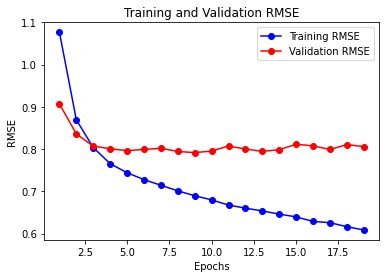

In [78]:
train_loss = history_dense.history['rmse']
val_loss = history_dense.history['val_rmse']

epochs = range(1, len(train_loss) + 1)

plt.plot(epochs, train_loss, 'bo-', label='Training RMSE')
plt.plot(epochs, val_loss, 'ro-', label='Validation RMSE')
plt.title('Training and Validation RMSE')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.legend()

plt.show()

## LSTM neural network

In [79]:
def lstm_io(
    df, # Pandas DataFrame with the data
    idx:[Int], # DataFrame indedx
    col:[str], # Column name
    p:Int # Number of lags
):
    # Return an (input, output) tuple for a dense_layer model
    
    assert len(idx) == len(col)

    batch_X, batch_y = [], []
    for i in range(len(idx)):
        X = df.iloc[idx[i]:(idx[i]+p)].values
        X[np.isnan(X)] = 0
        batch_X.append(X)
        batch_y.append(df.iloc[idx[i]+p][[col[i]]].values)
    
    return np.vstack(batch_X), np.vstack(batch_y)

In [80]:
lstm = layers.LSTM(units=64, return_sequences=True, return_state=False)
fl = layers.Flatten()

In [81]:
train_samples[0][:5].shape

(5, 24)

In [82]:
nn_lstm = keras.Sequential([
    layers.LSTM(units=64, return_sequences=True, return_state=False, dropout=0.1),
    #layers.LSTM(units=1, return_sequences=False, return_state=False, dropout=0.1),
    layers.Flatten(),
    layers.Dense(15, activation='relu'),
    layers.Dense(1)
])

In [83]:
assert nn_lstm(np.expand_dims(train_samples[0], axis=-1)).shape == train_samples[1].shape

In [84]:
nn_lstm.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (990, 24, 64)             │     16,896 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ flatten_2 (Flatten)             │ (990, 1536)               │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_75 (Dense)                │ (990, 15)                 │     23,055 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_76 (Dense)                │ (990, 1)                  │         16 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 39,967 (156.12 KB)

 Trainable params: 39,967 (156.12 KB)

 Non-trainable params: 0 (0.00 B)

In [85]:
nn_lstm.compile(
    loss=keras.losses.MeanSquaredError(),
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    metrics=[
        keras.metrics.RootMeanSquaredError(name="rmse")
    ]
)

In [86]:
history_lstm = nn_lstm.fit(
    x=train_samples[0],
    y=train_samples[1],
    batch_size=10,
    epochs=500,
    validation_data=valid_samples,
    callbacks=[keras.callbacks.EarlyStopping(patience=10)]
)

Epoch 1/500
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.8201 - rmse: 0.9051 - val_loss: 0.7144 - val_rmse: 0.8452
Epoch 2/500
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.6628 - rmse: 0.8124 - val_loss: 0.6550 - val_rmse: 0.8093
Epoch 3/500
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.6222 - rmse: 0.7883 - val_loss: 0.6021 - val_rmse: 0.7759
Epoch 4/500
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.5253 - rmse: 0.7243 - val_loss: 0.5815 - val_rmse: 0.7626
Epoch 5/500
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.5773 - rmse: 0.7591 - val_loss: 0.5524 - val_rmse: 0.7432
Epoch 6/500
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.5435 - rmse: 0.7370 - val_loss: 0.5926 - val_rmse: 0.7698
Epoch 7/500
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.5108 - rmse: 0.7140 - val_loss: 0.5727 - val_rmse: 0.7568
Epoch 8/500
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.5354 - rmse: 0.7308 - val_loss: 0.5272 - val_rmse: 0.7261
Epoch 9/500
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/st

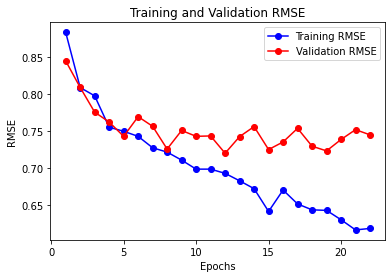

In [87]:
train_loss = history_lstm.history['rmse']
val_loss = history_lstm.history['val_rmse']

epochs = range(1, len(train_loss) + 1)

plt.plot(epochs, train_loss, 'bo-', label='Training RMSE')
plt.plot(epochs, val_loss, 'ro-', label='Validation RMSE')
plt.title('Training and Validation RMSE')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.legend()

plt.show()

## LSTM with other countries' inflation data

The difference between this and the previous one is that it is not only autoregressive, but also considers past data from other countries.

### Data formatting

In [100]:
def lstm_cty_io(
    df, # Pandas DataFrame with the data
    idx:[Int], # DataFrame indedx
    col:[str], # Column name
    p:Int # Number of lags
):
    # Return an (input, output) tuple for a dense_layer model
    
    assert len(idx) == len(col)

    batch_X, batch_y = [], []
    for i in range(len(idx)):
        X = df.iloc[idx[i]:(idx[i]+p)].values
        X[np.isnan(X)] = 0
        batch_X.append(X)
        batch_y.append(df.iloc[idx[i]+p][[col[i]]].values)
    
    return np.stack(batch_X, axis=0), np.vstack(batch_y)  #np.vstack(batch_X), np.vstack(batch_y)

In [101]:
lstm_cty_io(df=df_infl_train, idx=[3, 4, 5], col=['BR', 'BR', 'BR'], p=4)[0].shape

(3, 4, 61)

In [102]:
p = 24

idx, col = random_select(df_infl_train_n, p=p, n_samples=n_samples)
train_samples = lstm_cty_io(df=df_infl_train_n, idx=idx, col=col, p=p)

idx, col = random_select(df_infl_valid_n, p=p, n_samples=n_samples)
valid_samples = lstm_cty_io(df=df_infl_valid_n, idx=idx, col=col, p=p)

In [103]:
train_samples[0].shape

(1000, 24, 61)

### Model

In [137]:
nn_lstm_cty = keras.Sequential([
    layers.LSTM(units=1052, return_sequences=True, return_state=False, dropout=0.1),
    layers.LSTM(units=64, return_sequences=True, return_state=False, dropout=0.1),
    #layers.LSTM(units=1, return_sequences=False, return_state=False, dropout=0.1),
    layers.Flatten(),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)
])

In [138]:
nn_lstm_cty.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ lstm_12 (LSTM)                  │ ?                         │          0 │
│                                 │                           │  (unbuilt) │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ lstm_13 (LSTM)                  │ ?                         │          0 │
│                                 │                           │  (unbuilt) │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ flatten_8 (Flatten)             │ ?                         │          0 │
│                                 │                           │  (unbuilt) │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_87 (Dense)                │ ?                         │          0 │
│                                 │                           │  (unbuilt) │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_88 (Dense)                │ ?                         │          0 │
│                                 │                           │  (unbuilt) │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [139]:
assert nn_lstm_cty(train_samples[0]).shape == train_samples[1].shape

In [140]:
nn_lstm_cty.compile(
    loss=keras.losses.MeanSquaredError(),
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    metrics=[
        keras.metrics.RootMeanSquaredError(name="rmse")
    ]
)

In [141]:
train_samples[0].shape

(1000, 24, 61)

In [142]:
history_lstm_cty = nn_lstm_cty.fit(
    x=train_samples[0],
    y=train_samples[1],
    batch_size=20,
    epochs=500,
    validation_data=valid_samples,
    callbacks=[keras.callbacks.EarlyStopping(patience=10)]
)

Epoch 1/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 23s 423ms/step - loss: 0.9400 - rmse: 0.9688 - val_loss: 1.2223 - val_rmse: 1.1056
Epoch 2/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 20s 407ms/step - loss: 0.8863 - rmse: 0.9410 - val_loss: 1.4539 - val_rmse: 1.2058
Epoch 3/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 20s 397ms/step - loss: 0.9242 - rmse: 0.9611 - val_loss: 1.1974 - val_rmse: 1.0943
Epoch 4/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 21s 430ms/step - loss: 0.8625 - rmse: 0.9282 - val_loss: 1.0799 - val_rmse: 1.0392
Epoch 5/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 19s 387ms/step - loss: 0.7870 - rmse: 0.8866 - val_loss: 1.0528 - val_rmse: 1.0261
Epoch 6/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 17s 343ms/step - loss: 0.7795 - rmse: 0.8811 - val_loss: 1.0447 - val_rmse: 1.0221
Epoch 7/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 22s 446ms/step - loss: 0.8111 - rmse: 0.9004 - val_loss: 1.1703 - val_rmse: 1.0818
Epoch 8/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 24s 487ms/step - loss: 0.7684 - rmse: 0.8756 - val_loss: 1.0712 - val_rmse: 1.0350
Epoch 9/500
50/50 ━━━━━━

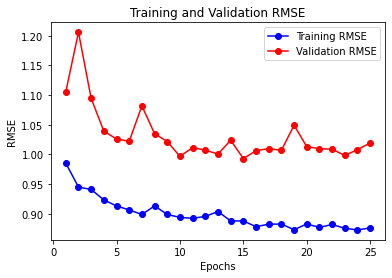

In [143]:
train_loss = history_lstm_cty.history['rmse']
val_loss = history_lstm_cty.history['val_rmse']

epochs = range(1, len(train_loss) + 1)

plt.plot(epochs, train_loss, 'bo-', label='Training RMSE')
plt.plot(epochs, val_loss, 'ro-', label='Validation RMSE')
plt.title('Training and Validation RMSE')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.legend()

plt.show()

## Model with date features

Repeating date features (eg, day in the week, month, quarter and year, week in the month, quarter and year, month in the quarter and year, and quarter in year) can be embedded and included in the model.

In [99]:
#nn_lstm_datefeat = layers.LSTM()

## Creating a TFT model

In [ ]:
tft = TemporalFusionTransformer(
    time_steps=12,
    input_size=20,
    output_size=4,
    category_counts=5,
    n_workers=2, # Number of multiprocessing workers

    # TFT params
    input_obs_loc=24,
    static_input_loc=24,
    known_regular_input_idx=24,
    known_categorical_input_idx=24,
    column_definition=None,
)

In [ ]:
tft.time_steps

# Test

In [ ]:
batch_size = 3
n_timesteps = 4

univariate_x = np.ones(shape=(batch_size, n_timesteps))
univariate_x = keras.ops.expand_dims(univariate_x, axis=-1)
univariate_x.shape

TensorShape([3, 4, 1])

In [ ]:
lstm = layers.LSTM(
    units=6,
    return_sequences=True,
    return_state=False,
)

In [ ]:
transf_x = lstm(univariate_x)
transf_x.shape, keras.ops.concatenate([transf_x, transf_x], axis=1).shape

(TensorShape([3, 4, 6]), TensorShape([3, 8, 6]))

In [ ]:
transf_x.shape

TensorShape([3, 14])

# References {.unnumbered}